---

# Price of Airbnb listings prediction
*Christos Kestritsalis*

---

## Outline

1. Introduction
    - 1.1. Import packages and adjust notebook settings
    - 1.2. Import training & test dataset
2. Exploratory Data Analysis
    - 2.1. Summary statistics
    - 2.2. Visual exploration of categorical columns
    - 2.3. Visual exploration of numerical columns
3. Data Preparation (Non-Text Features)
    - 3.1. Assign data types
    - 3.2. Fill in missing values
    - 3.3. Outlier handling
    - 3.4. Encode features
    - 3.5. Feature recovery
       - 3.5.1. Column host_days
       - 3.5.2. Column "amenities"
    - 3.6. Feature selection
        - 3.6.1. Pearson Correlation
        - 3.6.2. Fisher Score
4. Data Preparation (Text Features - NLP)
    - 4.1. Text Cleaning
    - 4.2. Most used words
    - 4.3. Sentiment Analysis
    - 4.4. Preparation for feature selection
    - 4.5. Text Feature selection
5. Model training and selection
    - 5.1. Non-text model training for benchmarking
    - 5.2. RNN architecture selection
        - 5.2.1. GRU
        - 5.2.2. LSTM
        - 5.2.3. Bidirectional LSTM
    - 5.3. Final model parameter tuning
    - 5.4. Final model training
    - 5.5. Final model create predictions

6. Conclusion

---

## 1. Introduction

---

Goal of the following exposition is to **predict property prices** for Airnbnb listings in London. The predictions will be based on dataset of 55,284 property listings containing 41 listing attributes (excluding index). In addition, dataset of reviews for the listings from different reviewers will be used (size approx 1.5 mil reviews) for additional information mining (sentiment analysis). First, train and test datasets are explored and first insights are derived. Secondly, appropriate transformations are applied on both text and nontext features to prepare for using into a neural network. Furthermore, text features are processed separately and sentiment analysis is performed on reviews dataset to extract further value from text features. In the last part, different sequential (recurrent) network setups are explored and finally a setup is selected to train on our data and create the final predictions for the test set. Finally, in the conclusions the most important insights and conclusions from the exposition are revisited.

Link below to supporting files:
- train.pkl
- test.pkl
- train_text_columns_clean.pkl
- test_text_columns_clean.pkl
- sentiment_analysis.pkl
- pretrained embeddings file

https://drive.google.com/drive/folders/1wcAfaWiZBMri0u-hC1InktHHgEXihqBQ?usp=sharing

### 1.1. Import packages and adjust notebook settings

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from datetime import date, datetime
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, LSTM, Embedding, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.core import Dropout
import tensorflow as tf
from tensorflow.keras import activations, losses
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import re
import time
import pickle
from bs4 import BeautifulSoup
import warnings
import collections
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models.phrases import Phrases

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,10)
pd.set_option("display.precision", 3)
pd.set_option("display.max_rows", 100, "display.max_columns", None)
sns.set(style='darkgrid')

### 1.2. Import training dataset

In [136]:
PATH = "C:/Users/Christos/Desktop/final_assignment/" # Setting up dataset path - to be adjusted according to notebook environment
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

---

## 2. Exploratory Data Analysis

---

### 2.1. Summary Statistics

First we take a look at dimensionality of data:

In [137]:
print('Dimensionality of the data is {}'.format(train.shape))
print('The data set has {} cases (lines).'.format(train.shape[0]))
print('The total number of elements is {}.'.format(train.size))

Dimensionality of the data is (55284, 42)
The data set has 55284 cases (lines).
The total number of elements is 2321928.


In [138]:
print('Dimensionality of the data is {}'.format(test.shape))
print('The data set has {} cases (lines).'.format(test.shape[0]))
print('The total number of elements is {}.'.format(test.size))

Dimensionality of the data is (29769, 41)
The data set has 29769 cases (lines).
The total number of elements is 1220529.


Taking a look at the first few lines of data:

In [139]:
train.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,2012-04-18,within an hour,100%,t,1.0,t,f,Greenwich,Greenwich,SE10 8SX,51.475,-0.011,Townhouse,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{Wifi,""Paid parking off premises"",Heating,Wash...",35.0,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,2014-05-29,within a few hours,100%,t,1.0,t,t,LB of Haringey,Haringey,N8 8NR,51.583,-0.124,Guesthouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Free parking on premises"",Breakfast,...",75.0,2,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,2019-06-28,within an hour,100%,f,2.0,t,f,LB of Merton,Merton,SW19 1DG,51.416,-0.186,Apartment,Entire home/apt,5,1.0,1.0,2.0,Real Bed,"{Wifi,Kitchen,""Paid parking off premises"",Heat...",120.0,2,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,2012-08-24,within a few hours,100%,f,1.0,t,f,Clapham,Lambeth,SW4 9EF,51.456,-0.141,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Heating,Washer,""Smoke detecto...",50.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,2016-09-09,within an hour,100%,t,2.0,t,f,LB of Lambeth,Lambeth,SE11 5TL,51.481,-0.112,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",H...",104.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF


Observations after a first look: We have several columns with text given by the listing owner. For those fields we will need to apply NLP techniques to extract useful information. In addition, there is one url feature, one date feature and several features describing the *host*. In addition, there are features describing the *neighbourhood* and the *property*. Also there is geocode information. Lastly *review scores* regarding the listing and specific subcategories are available.

In [140]:
test.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Ladbroke Grove Stylish Portobello Apartment,"Large, bright and contemporary flat located in...",NaN,"Large, bright and contemporary flat located in...",none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/9e15bc56-a...,28086957,2015-02-21,NaN,NaN,f,1.0,t,t,RB of Kensington and Chelsea,Kensington and Chelsea,W10 6HJ,51.518,-0.211,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,W...",1,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.89,0FEMC4VA5U
1,Contemporary Design in Notting Hill,Stylish design on a beautiful tree lined stree...,The (Phone number hidden by Airbnb) ) is thoug...,Stylish design on a beautiful tree lined stree...,none,"Notting Hill is a trendy, artistic, bohemian n...",There are 2 underground stations within walkin...,NaN,https://a0.muscache.com/im/pictures/c2ea8799-e...,16965290,2014-06-18,within an hour,100%,t,14.0,t,f,Westbourne Green,Westminster,W2 5DH,51.517,-0.197,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Heating,Washer,Dryer,""Smoke d...",1,97.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,2.50,PQ2BYEO0QR
2,En-suite double bedroom,Quiet en-suite double bedroom in our lovely ho...,NaN,Quiet en-suite double bedroom in our lovely ho...,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/4b86abd0-0...,4363076,2012-12-09,NaN,NaN,f,1.0,t,t,LB of Camden,Camden,NW1 8DU,51.543,-0.147,House,Private room,2,2.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,3FP6WFHUBN
3,Double room with balcony in magnificent penthouse,My place is close to Aldgate . You’ll love my ...,NaN,My place is close to Aldgate . You’ll love my ...,none,NaN,NaN,"- No parties, events or guests",https://a0.muscache.com/im/pictures/23ea2939-6...,7603738,2013-07-20,NaN,NaN,f,1.0,t,t,LB of Tower Hamlets,Tower Hamlets,E1,51.512,-0.064,Apartment,Private room,1,1.5,1.0,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Dryer,""S...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,GG0V2KDG90
4,The Bockery Suite 2 Chelsea,This 26m2 Suite comprises of 1 bedroom and 1 b...,"Whether it's just for you or your family, whet...",This 26m2 Suite comprises of 1 bedroom and 1 b...,none,When you have had your fill of relaxing in the...,Our visitors often tell us that they had no id...,What you do in the privacy of your own room is...,https://a0.muscache.com/im/pictures/64910777/2...,26586101,2015-01-23,a few days or more,0%,f,3.0,t,t,Chelsea,Kensington and Chelsea,SW10 0TB,51.484,-0.185,Boutique hotel,Private room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Pets allowed"",""Pets live on this pro...",2,98.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,0.95,TZVVK4YSIO


In [141]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         55270 non-null  object 
 1   summary                      52330 non-null  object 
 2   space                        38403 non-null  object 
 3   description                  53558 non-null  object 
 4   experiences_offered          55284 non-null  object 
 5   neighborhood_overview        35778 non-null  object 
 6   transit                      35477 non-null  object 
 7   house_rules                  31906 non-null  object 
 8   picture_url                  55284 non-null  object 
 9   host_id                      55284 non-null  int64  
 10  host_since                   55173 non-null  object 
 11  host_response_time           37482 non-null  object 
 12  host_response_rate           37482 non-null  object 
 13  host_is_superhos

First, data type allocation is not ideal. Data type classification is as following:

**string** (obj)

- name
- summary
- space
- description
- experiences_offered
- neighborhood_overview
- transit
- house_rules
- picture_url
- host_id
- host_response_time → convert to somthing numerical for usability
- neighbourhood → possibly unecessary since neighbourhood_clean is also available
- neighbourhood_clean
- property_type
- room_type
- bed_type
- cancellation_policy
- listing_id

**Int**

- host_total listings
- accomodates
- bedrooms
- beds
- price
- guests_included
- review_scores_rating
- review_scores_accuracy
- review_scores_cleaning
- review_scores_checkin
- review_scores_communication
- review_scores_location
- review_scores_value

**Float**

- host response rate
- bathrooms
- reviews_per_month

**Date**

- host_since

**Boolean**

- host_is_superhost
- host_has_profile_pic
- host_identity verified

**Geographical/geocode**

- zipcode
- latitude
- longtitude

**List**

- amenities → remove unecessary characters and encode

In addition we notice that there are *null* values in several columns

In [142]:
train_columns = list(train.columns)

In [143]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29769 entries, 0 to 29768
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         29759 non-null  object 
 1   summary                      28192 non-null  object 
 2   space                        20712 non-null  object 
 3   description                  28826 non-null  object 
 4   experiences_offered          29769 non-null  object 
 5   neighborhood_overview        19218 non-null  object 
 6   transit                      19097 non-null  object 
 7   house_rules                  17189 non-null  object 
 8   picture_url                  29769 non-null  object 
 9   host_id                      29769 non-null  int64  
 10  host_since                   29704 non-null  object 
 11  host_response_time           20197 non-null  object 
 12  host_response_rate           20197 non-null  object 
 13  host_is_superhos

Next we take a look at summary statistscs for train dataset:

In [144]:
train.describe(include = "all")

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
count,55270,52330,38403,53558,55284,35778,35477,31906,55284,5.528e+04,55173,37482,37482,55173,55173.000,55173,55173,55137,55284,54012,55284.000,55284.000,55284,55284,55284.000,55214.000,55222.000,55022.000,55284,55284,55284.000,55284.000,41869.000,41836.000,41842.000,41801.000,41838.000,41804.000,41804.000,55284,42904.000,55284
unique,54042,49111,35719,51626,5,30233,31098,24790,54423,NaN,3446,4,69,2,NaN,2,2,149,33,26556,NaN,NaN,38,4,NaN,NaN,NaN,NaN,5,50376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,55284
top,Double room,"Featured in The New York Times, The Wall Stree...",Situated in an excellent central location. Tow...,My Luxury Two Bedroom apartment is located min...,none,Conveniently located in Maida Vale one of Lond...,Transport links are excellent with convenient ...,- The lead guest will be required to sign an O...,https://a0.muscache.com/im/pictures/d029c664-c...,NaN,2015-05-21,within an hour,100%,f,NaN,t,f,City of Westminster,Westminster,E1,NaN,NaN,Apartment,Entire home/apt,NaN,NaN,NaN,NaN,Real Bed,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict_14_with_grace_period,NaN,4562AIHU5V
freq,28,125,20,17,54222,40,47,210,7,NaN,413,23982,25860,46982,NaN,55013,35346,3292,6011,292,NaN,NaN,36986,30504,NaN,NaN,NaN,NaN,54864,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24102,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.818e+07,NaN,NaN,NaN,NaN,20.704,NaN,NaN,NaN,NaN,NaN,51.510,-0.127,NaN,NaN,3.132,1.284,1.374,1.711,NaN,NaN,104.309,1.575,92.533,9.503,9.261,9.622,9.653,9.542,9.263,NaN,1.164,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.013e+07,NaN,NaN,NaN,NaN,117.030,NaN,NaN,NaN,NaN,NaN,0.047,0.094,NaN,NaN,1.930,0.567,0.859,1.224,NaN,NaN,83.740,1.263,10.031,0.982,1.139,0.895,0.874,0.810,1.033,NaN,1.354,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.697e+03,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,51.295,-0.497,NaN,NaN,1.000,0.000,0.000,0.000,NaN,NaN,10.000,1.000,20.000,2.000,2.000,2.000,2.000,2.000,2.000,NaN,0.010,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.526e+07,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,51.485,-0.188,NaN,NaN,2.000,1.000,1.000,1.000,NaN,NaN,45.000,1.000,90.000,9.000,9.000,10.000,10.000,9.000,9.000,NaN,0.240,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.817e+07,NaN,NaN,NaN,NaN,2.000,NaN,NaN,NaN,NaN,NaN,51.514,-0.125,NaN,NaN,2.000,1.000,1.000,1.000,NaN,NaN,80.000,1.000,96.000,10.000,10.000,10.000,10.000,10.000,9.000,NaN,0.730,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.449e+08,NaN,NaN,NaN,NaN,5.000,NaN,NaN,NaN,NaN,NaN,51.538,-0.069,NaN,NaN,4.000,1.500,2.000,2.000,NaN,NaN,130.000,2.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,NaN,1.570,NaN


Observations at this point:
* experiences_offered has 54,222 out of 55,284 observations = "none"
* host_total_listings_count mean = 20.70, but median = 2  → indication of outliers
* host_has_profile_pic, bed_type: almost all of observations have value true

In [145]:
test.describe(include='all')

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
count,29759,28192,20712,28826,29769,19218,19097,17189,29769,2.977e+04,29704,20197,20197,29704,29704.000,29704,29704,29683,29769,29134,29769.000,29769.000,29769,29769,29769.000,29719.000,29740.000,29627.000,29769,29769,29769.000,22569.000,22550.000,22556.000,22539.000,22556.000,22538.000,22536.000,29769,23141.000,29769
unique,29266,26940,19781,28136,5,17032,17379,13921,29504,NaN,3318,4,66,2,NaN,2,2,149,33,17317,NaN,NaN,34,4,NaN,NaN,NaN,NaN,5,27912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,29769
top,Centrally Located Tower Hill/Aldagte East Studios,"Featured in The New York Times, The Wall Stree...",There is an en-suite bathroom which is a pleas...,.,none,East London is a lively and unique area with p...,Transport links are excellent with convenient ...,- The lead guest will be required to sign an O...,https://a0.muscache.com/im/pictures/3a5e9891-4...,NaN,2015-05-21,within an hour,100%,f,NaN,t,f,City of Westminster,Westminster,E1,NaN,NaN,Apartment,Entire home/apt,NaN,NaN,NaN,NaN,Real Bed,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict_14_with_grace_period,NaN,K7NPR1ZXH5
freq,12,62,15,13,29194,23,27,128,7,NaN,240,12859,13887,25197,NaN,29605,19079,1813,3306,162,NaN,NaN,20000,16525,NaN,NaN,NaN,NaN,29533,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12968,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.748e+07,NaN,NaN,NaN,NaN,21.113,NaN,NaN,NaN,NaN,NaN,51.510,-0.128,NaN,NaN,3.154,1.289,1.389,1.718,NaN,NaN,1.583,92.530,9.509,9.267,9.625,9.655,9.538,9.259,NaN,1.171,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.944e+07,NaN,NaN,NaN,NaN,120.093,NaN,NaN,NaN,NaN,NaN,0.046,0.093,NaN,NaN,1.935,0.563,0.866,1.215,NaN,NaN,1.241,10.188,0.985,1.123,0.896,0.877,0.826,1.035,NaN,1.371,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.775e+03,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,51.299,-0.496,NaN,NaN,1.000,0.000,0.000,0.000,NaN,NaN,1.000,20.000,2.000,2.000,2.000,2.000,2.000,2.000,NaN,0.010,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.542e+07,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,51.486,-0.188,NaN,NaN,2.000,1.000,1.000,1.000,NaN,NaN,1.000,90.000,9.000,9.000,10.000,10.000,9.000,9.000,NaN,0.230,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.808e+07,NaN,NaN,NaN,NaN,2.000,NaN,NaN,NaN,NaN,NaN,51.514,-0.125,NaN,NaN,2.000,1.000,1.000,1.000,NaN,NaN,1.000,96.000,10.000,10.000,10.000,10.000,10.000,9.000,NaN,0.710,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.443e+08,NaN,NaN,NaN,NaN,5.000,NaN,NaN,NaN,NaN,NaN,51.538,-0.069,NaN,NaN,4.000,1.500,2.000,2.000,NaN,NaN,2.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,NaN,1.580,NaN


### 2.2. Visual exploration of categorical columns

In order to get a better sense of the distribution of our categorical features we are going to visualise them in countplots:

Wall time: 1 s


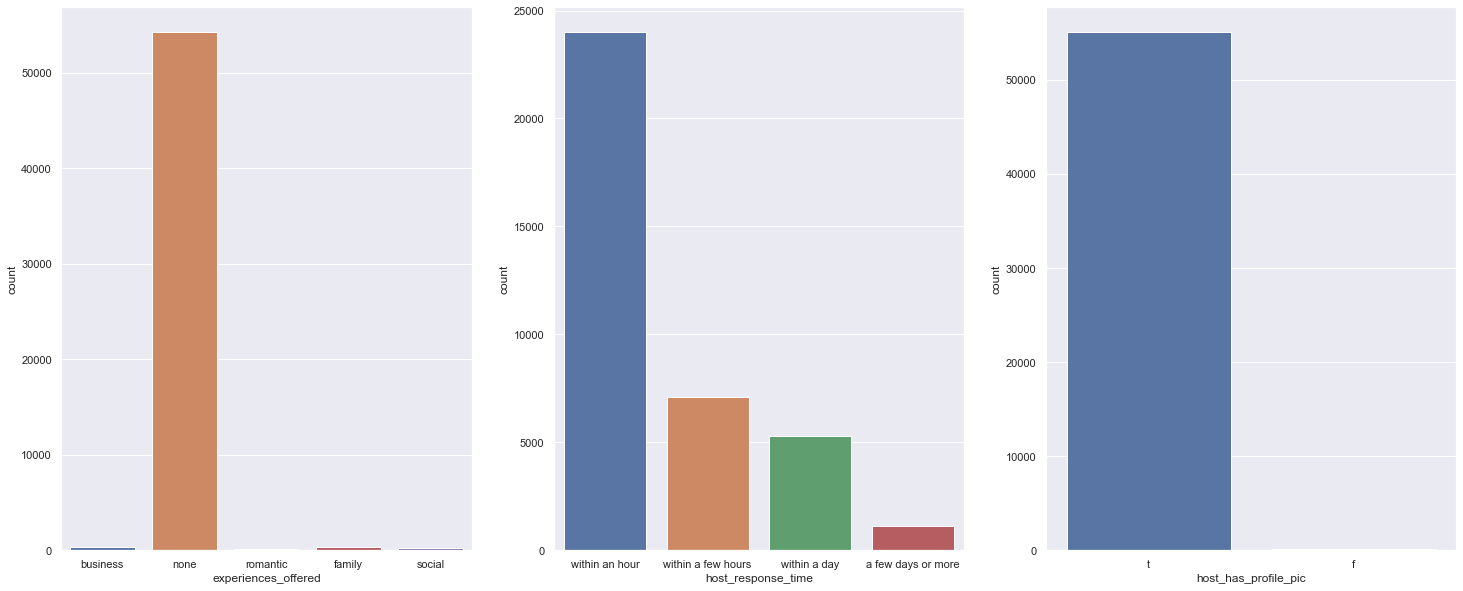

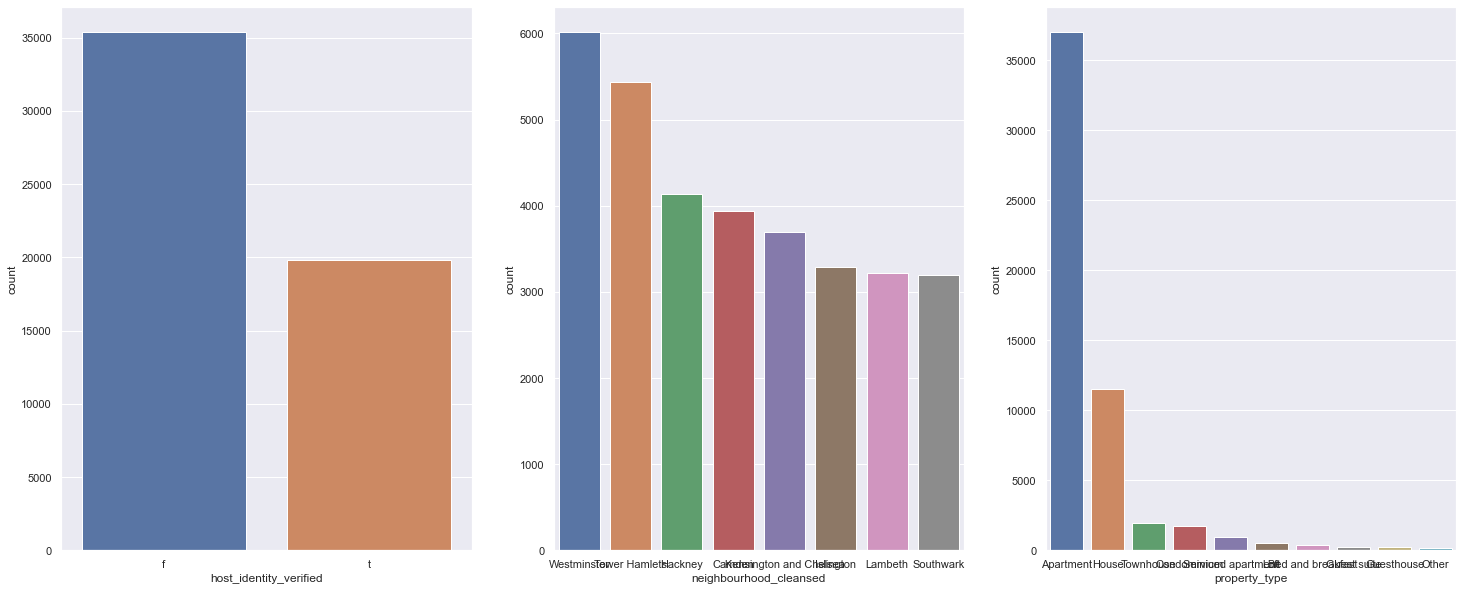

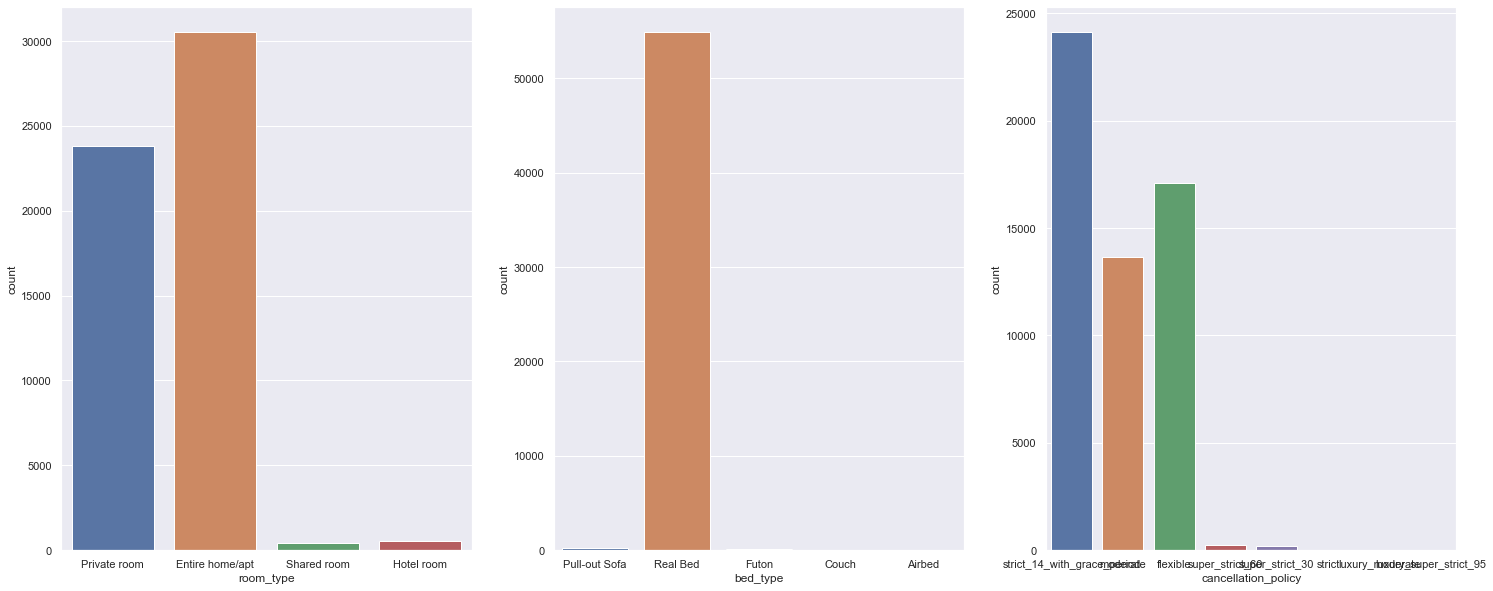

In [146]:
%%time
fig, ax =plt.subplots(1,3)
sns.countplot(train.experiences_offered, ax=ax[0])
sns.countplot(train.host_response_time, ax=ax[1])
sns.countplot(train.host_has_profile_pic, ax=ax[2])
fig.show()

fig, ax =plt.subplots(1,3)
sns.countplot(train.host_identity_verified, ax=ax[0])
sns.countplot(train.neighbourhood_cleansed, order=train.neighbourhood_cleansed.value_counts().index[:8], ax=ax[1])
sns.countplot(train.property_type, order=train.property_type.value_counts().index[:10], ax=ax[2])
fig.show()

fig, ax =plt.subplots(1,3)
sns.countplot(train.room_type, ax=ax[0])
sns.countplot(train.bed_type, ax=ax[1])
sns.countplot(train.cancellation_policy, ax=ax[2])
fig.show()

<AxesSubplot:xlabel='neighbourhood_cleansed', ylabel='count'>

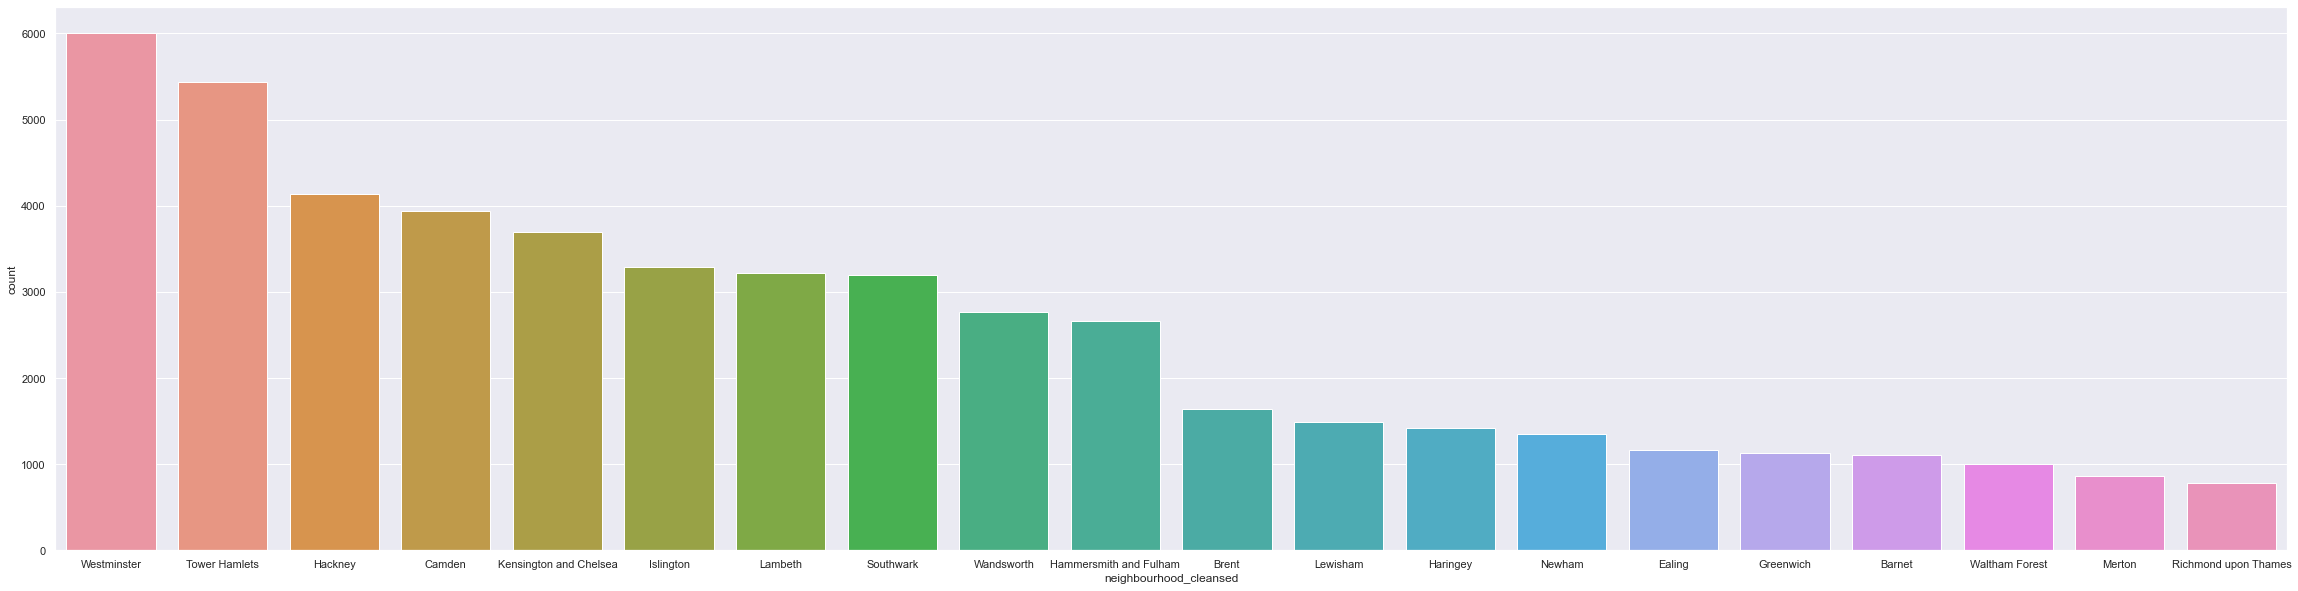

In [147]:
# Calculate neighbourhoods with more than 1000 listings
neigh_cleansed_freq = train.neighbourhood_cleansed.value_counts()
top_neighbourhoods = filter(lambda x: neigh_cleansed_freq>10000, neigh_cleansed_freq) # filtering operation does not work

# Display countplot only for neighbourhood_cleansed
plt.rcParams["figure.figsize"] = (40,10)
sns.countplot(train.neighbourhood_cleansed, order=train.neighbourhood_cleansed.value_counts().index[:20])

Observations:
* As seen earlier, experiences_offered is predominantly value = None
* Most frequent value for host_response_time = within an hour
* host_has_profile_pic and host_verified predominantly True. We don't expect this feature to hold much predictive value.
* Most popular neighbourhoods: Westminster, Tower Hamlets, Hackney
* Types of properties listed are predominantly Apartment, House, Condominium or Townhouse
* Room type predominantly private room or entire home/apartment
* Bed type predominantly real bed
* Cancellation policy: mostly strict days with grace period, moderate or flexible

Closer look at neighbourhood_cleansed:

### 2.3. Visual exploration of float columns

In [148]:
# Select only integer and float columns
numeric_columns = train.select_dtypes(include = ["int32", "int64", "float32", "float64"])

# Remove columns latitude and longtitude as they are not relevant for this type of analysis
numeric_columns.drop(columns=["latitude", "longitude"], inplace=True)

array([[<AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_total_listings_count'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'guests_included'}>],
       [<AxesSubplot:title={'center':'review_scores_rating'}>,
        <AxesSubplot:title={'center':'review_scores_accuracy'}>,
        <AxesSubplot:title={'center':'review_scores_cleanliness'}>,
        <AxesSubplot:title={'center':'review_scores_checkin'}>],
       [<AxesSubplot:title={'center':'review_scores_communication'}>,
        <AxesSubplot:title={'center':'review_scores_location'}>,
        <AxesSubplot:title={'center':'review_scores_value'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>]], dtype=object)

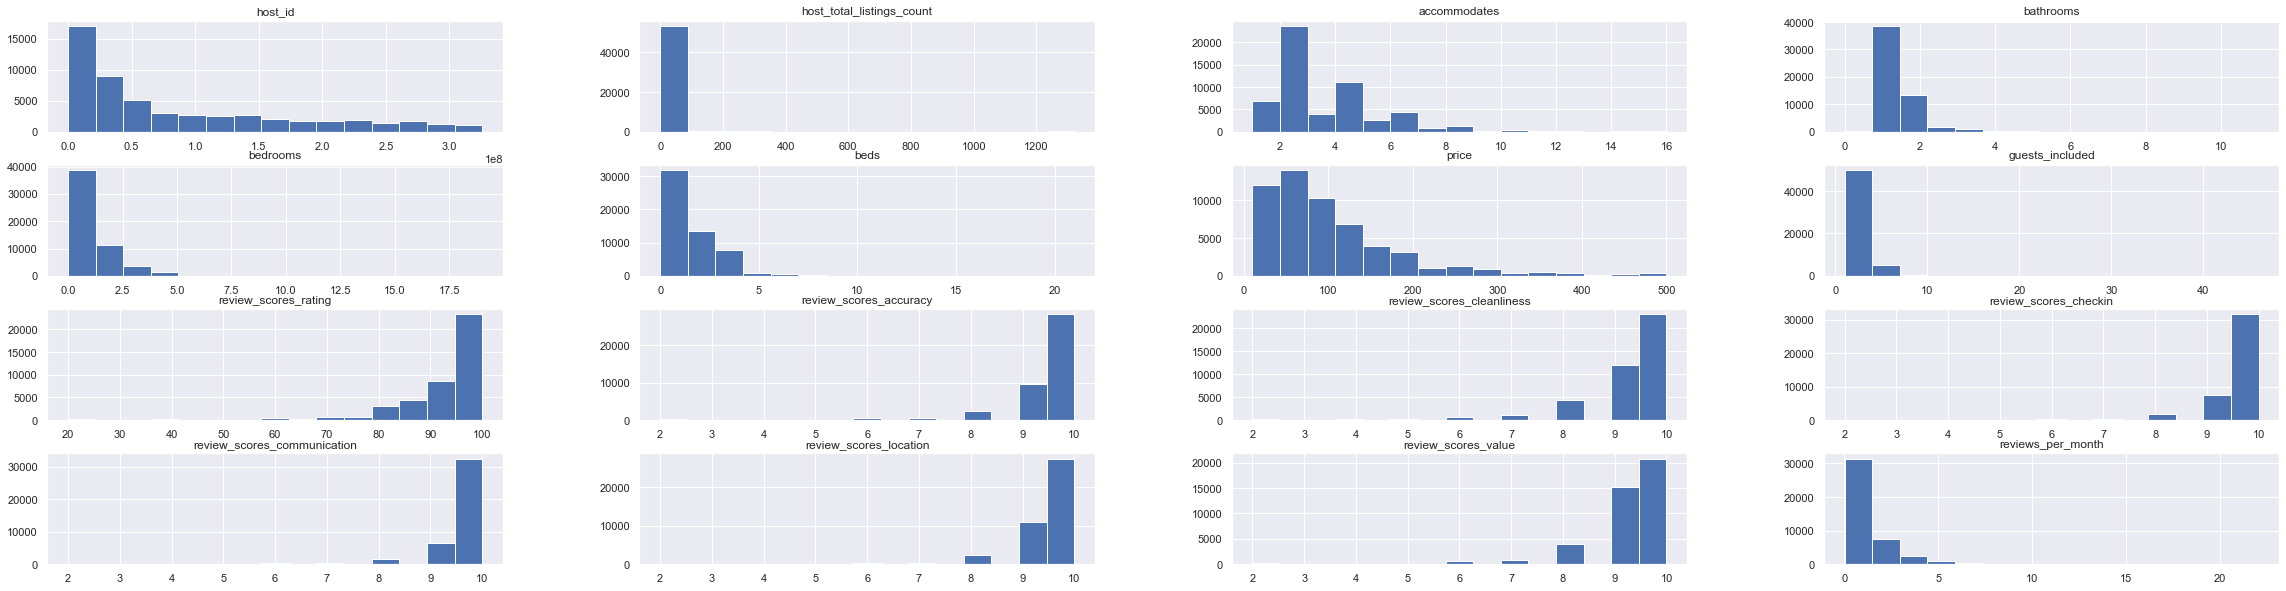

In [149]:
# One histogram for each numeric variable
numeric_columns.hist(bins=15)

Observations:
* accommodates: Data is left-skewed, most listings accomodate 2 or 4 guests
* bathrooms: most listings < 4 bathrooms
* bedrooms: most listings < 3 bedrooms
* beds: <4 beds
* guests_included: <6 guests
* host_response_rate: predominantly >0.8
* host_total_listings_count: most hosts have 1 listing
* price (target variable): left-skewed, mostly < 200
* review_scores columns (accuracy, checkin, cleanliness, communication, location, rating, value): data predominantly right-skewed or zero
* reviews_per_month: most listings have 1 review per month, almost all <5

## 3. Data Preparation (Non-Text Features)

### 3.1. Data Types

Next we are going to look at each feature's _data type_ and convert/transform accordingly:

#### Train data

In [150]:
# name: type str OK
# summary: type str OK
# space: type str OK
# description: type str OK
# experiences_offered: type str OK
# neighbourhood_overview: type str OK
# transit: type str OK
# house_rules: type str OK
# picture_url: type str OK

# host_id: int data type not optimal, as we are not going to make calculations with this field. Best to convert to string:
train.host_id = train.host_id.astype("str", copy=False)

# host_since: convert to date in order to be able to apply date calculations
train.host_since = train.host_since.astype("datetime64", copy = False)

# host_response_time: str OK

# host_response_rate: str, convert to float (percentage)
train.host_response_rate = train.host_response_rate.str.replace("%", "")
train.host_response_rate = train.host_response_rate.astype("float")
train.host_response_rate = train.host_response_rate.apply(lambda x: x/100)

# host_is_superhost: str, convert to boolean
train.host_is_superhost = train.host_is_superhost.astype("bool")

# host_total_listings_count: convert to int. For NAs we assume value 0
train.host_total_listings_count.fillna(0, inplace = True)
train.host_total_listings_count = train.host_total_listings_count.astype("int")

# host_has_profile_pic: convert to boolean
train.host_has_profile_pic = train.host_has_profile_pic.astype("bool")

# host_identity_verified: convert to boolean
train.host_identity_verified = train.host_identity_verified.astype("bool")

# neighbourhood: str OK
# neighbourhood_cleansed: str OK
# zipcode: str OK
# latitude: float OK
# longitude: float OK
# 'property_type': str OK
# 'room_type': str OK
# 'accommodates': int OK (converting to int32)
train.accommodates = train.accommodates.astype("int")

# 'bathrooms': float OK
# 'bedrooms': convert to int
train.bedrooms.fillna(0, inplace = True)
train.bedrooms = train.bedrooms.astype("int")

# 'beds': convert to int
train.beds.fillna(0, inplace = True)
train.beds = train.beds.astype("int")

# 'bed_type': str OK
# 'amenities': str OK (list)
# 'price': float OK

# 'guests_included': int OK, converting to 32 bit
train.guests_included = train.guests_included.astype("int")

# 'review_scores_rating': no floating point needed, convert to int: fillna with 0 for now
train.review_scores_rating.fillna(0, inplace = True)
train.review_scores_rating = train.review_scores_rating.astype("int")

# 'review_scores_accuracy': convert to int:
train.review_scores_accuracy.fillna(0, inplace = True)
train.review_scores_accuracy = train.review_scores_accuracy.astype("int")

# 'review_scores_cleanliness': convert to int:
train.review_scores_cleanliness.fillna(0, inplace = True)
train.review_scores_cleanliness = train.review_scores_cleanliness.astype("int")

# 'review_scores_checkin': convert to int:
train.review_scores_checkin.fillna(0, inplace = True)
train.review_scores_checkin = train.review_scores_checkin.astype("int")

# 'review_scores_communication': convert to int:
train.review_scores_communication.fillna(0, inplace = True)
train.review_scores_communication = train.review_scores_communication.astype("int")

# 'review_scores_location': convert to int:
train.review_scores_location.fillna(0, inplace = True)
train.review_scores_location = train.review_scores_location.astype("int")

# 'review_scores_value': convert to int:
train.review_scores_value.fillna(0, inplace = True)
train.review_scores_value = train.review_scores_value.astype("int")

# 'cancellation_policy': str OK for now, later category
# 'reviews_per_month': float OK
# 'listing_id': str OK

train.dtypes

name                                   object
summary                                object
space                                  object
description                            object
experiences_offered                    object
neighborhood_overview                  object
transit                                object
house_rules                            object
picture_url                            object
host_id                                object
host_since                     datetime64[ns]
host_response_time                     object
host_response_rate                    float64
host_is_superhost                        bool
host_total_listings_count               int32
host_has_profile_pic                     bool
host_identity_verified                   bool
neighbourhood                          object
neighbourhood_cleansed                 object
zipcode                                object
latitude                              float64
longitude                         

#### Apply to test

In [151]:
test.host_id = test.host_id.astype("str", copy=False)
test.host_since = test.host_since.astype("datetime64", copy = False)
test.host_response_rate = test.host_response_rate.str.replace("%", "")
test.host_response_rate = test.host_response_rate.astype("float")
test.host_response_rate = test.host_response_rate.apply(lambda x: x/100)

test.host_is_superhost = test.host_is_superhost.astype("bool")
test.host_total_listings_count.fillna(0, inplace = True)
test.host_total_listings_count = test.host_total_listings_count.astype("int")
test.host_has_profile_pic = test.host_has_profile_pic.astype("bool")
test.host_identity_verified = test.host_identity_verified.astype("bool")
test.accommodates = test.accommodates.astype("int")
test.bedrooms.fillna(0, inplace = True)
test.bedrooms = test.bedrooms.astype("int")
test.beds.fillna(0, inplace = True)
test.beds = test.beds.astype("int")
test.guests_included = test.guests_included.astype("int")
test.review_scores_rating.fillna(0, inplace = True)
test.review_scores_rating = test.review_scores_rating.astype("int")
test.review_scores_accuracy.fillna(0, inplace = True)
test.review_scores_accuracy = test.review_scores_accuracy.astype("int")

test.review_scores_cleanliness.fillna(0, inplace = True)
test.review_scores_cleanliness = test.review_scores_cleanliness.astype("int")

test.review_scores_checkin.fillna(0, inplace = True)
test.review_scores_checkin = test.review_scores_checkin.astype("int")

test.review_scores_communication.fillna(0, inplace = True)
test.review_scores_communication = test.review_scores_communication.astype("int")

test.review_scores_location.fillna(0, inplace = True)
test.review_scores_location = test.review_scores_location.astype("int")

test.review_scores_value.fillna(0, inplace = True)
test.review_scores_value = test.review_scores_value.astype("int")

## 3.2. Error & null handling

In [152]:
# Number of nulls in each feature
train.isnull().sum()

name                              14
summary                         2954
space                          16881
description                     1726
experiences_offered                0
neighborhood_overview          19506
transit                        19807
house_rules                    23378
picture_url                        0
host_id                            0
host_since                       111
host_response_time             17802
host_response_rate             17802
host_is_superhost                  0
host_total_listings_count          0
host_has_profile_pic               0
host_identity_verified             0
neighbourhood                    147
neighbourhood_cleansed             0
zipcode                         1272
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         70
bedrooms                           0
b

In [153]:
# Several columns have null/missing values. Specifically:

# name                              14 : fill null with blank text
train.name = train.name.fillna("")

# summary                         2954 : fill null with blank text
train.summary = train.summary.fillna("")

# space                          16881 : fill null with blank text
train.space = train.space.fillna("")

# description                     1726 : fill null with blank text
train.description = train.description.fillna("")

# neighborhood_overview          19506: fill null with blank text 
train.neighborhood_overview = train.neighborhood_overview.fillna("")

# transit                        19807: fill null with blank text
train.transit = train.transit.fillna("")

# house_rules                    23378: fill null with blank text
train.house_rules = train.house_rules.fillna("")

# host_since                       111: fill null with mode value
train.host_since[train.host_since.isnull()] = train.host_since.mode()[0]  # the index [0] ensures that we only extract the value from the result of calling mode()

# host_response_time             17802: nulls as new category "not specified"
train.host_response_time = train.host_response_time.fillna("not specified")

# host_response_rate             17802: fill in with mean=0.9, as median = 1.0, which seems more biased
train.host_response_rate = train.host_response_rate.fillna(train.host_response_rate.mean())

# # neighbourhood                    147: fillna with value from neighbourhood_cleansed
# train.neighbourhood = train.neighbourhood.fillna(train.neighbourhood_cleansed)

# zipcode                         1272: fill with "not specified"
train.zipcode = train.zipcode.fillna("not specified")

# bathrooms                         70: fill with mean (median would also be ok)
train.bathrooms = train.bathrooms.fillna(train.bathrooms.mean())

# reviews_per_month              12380: fill with mean (median would also be ok)
train.reviews_per_month = train.reviews_per_month.fillna(train.reviews_per_month.mean())

train.isnull().sum()

name                             0
summary                          0
space                            0
description                      0
experiences_offered              0
neighborhood_overview            0
transit                          0
house_rules                      0
picture_url                      0
host_id                          0
host_since                       0
host_response_time               0
host_response_rate               0
host_is_superhost                0
host_total_listings_count        0
host_has_profile_pic             0
host_identity_verified           0
neighbourhood                  147
neighbourhood_cleansed           0
zipcode                          0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bathrooms                        0
bedrooms                         0
beds                             0
bed_type            

#### Apply to test

In [154]:
test.name = test.name.fillna("")
test.summary = test.summary.fillna("")
test.space = test.space.fillna("")
test.description = test.description.fillna("")
test.neighborhood_overview = test.neighborhood_overview.fillna("")
test.transit = test.transit.fillna("")
test.house_rules = test.house_rules.fillna("")
test.host_since[test.host_since.isnull()] = test.host_since.mode()[0]
test.host_response_time = test.host_response_time.fillna("not specified")
test.host_response_rate = test.host_response_rate.fillna(test.host_response_rate.mean())
test.zipcode = test.zipcode.fillna("not specified")
test.bathrooms = test.bathrooms.fillna(test.bathrooms.mean())
test.reviews_per_month = test.reviews_per_month.fillna(test.reviews_per_month.mean())

## 3.3. Outlier handling

<AxesSubplot:>

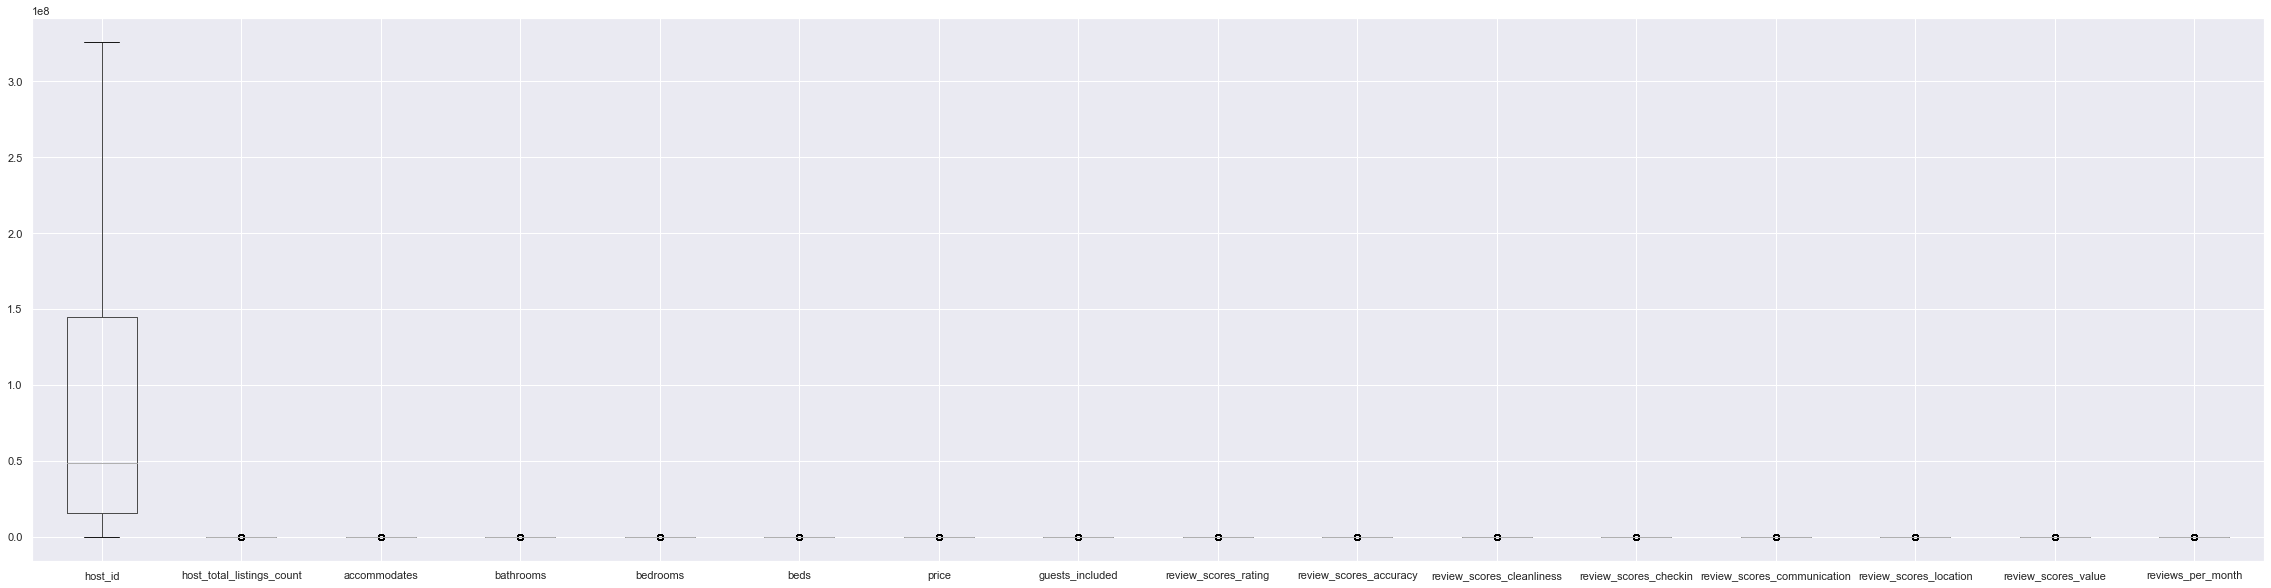

In [155]:
# Explore visually with boxplot
numeric_columns.boxplot()

A closer look at the numbers:

In [156]:
numeric_columns.describe()
# Good candidates for outliers:
# "host_total_listings_count" "price", "guests_included", "reviews_per_month"

,host_id,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,5.528e+04,55173.000,55284.000,55214.000,55222.000,55022.000,55284.000,55284.000,41869.000,41836.000,41842.000,41801.000,41838.000,41804.000,41804.000,42904.000
mean,8.818e+07,20.704,3.132,1.284,1.374,1.711,104.309,1.575,92.533,9.503,9.261,9.622,9.653,9.542,9.263,1.164
std,9.013e+07,117.030,1.930,0.567,0.859,1.224,83.740,1.263,10.031,0.982,1.139,0.895,0.874,0.810,1.033,1.354
min,2.697e+03,0.000,1.000,0.000,0.000,0.000,10.000,1.000,20.000,2.000,2.000,2.000,2.000,2.000,2.000,0.010
25%,1.526e+07,1.000,2.000,1.000,1.000,1.000,45.000,1.000,90.000,9.000,9.000,10.000,10.000,9.000,9.000,0.240
50%,4.817e+07,2.000,2.000,1.000,1.000,1.000,80.000,1.000,96.000,10.000,10.000,10.000,10.000,10.000,9.000,0.730
75%,1.449e+08,5.000,4.000,1.500,2.000,2.000,130.000,2.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,1.570
max,3.257e+08,1321.000,16.000,11.000,19.000,21.000,500.000,46.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,22.040


Good candidates for outliers seem to be the following features: "host_total_listings_count" "price", "guests_included", "reviews_per_month"

In [157]:
# Function to handle outliers based on Tuckey's rule
def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a contant value equal to the IQR
    times a factor, which, following Tuckey's rule, we set to 1.5 by default
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

We see that possible candidates for outlying values are dimensions _price_ and _host_total_listings_. From the boxplot, as well as from checking min, max and mean values, we can see that e.g. for _host_total_listings_ max = 1321, which seems unnaturally large e.g. for one host to rent out 1321 listings, especially when the mean value is around 20. This could be explained e.g. if the host is a company. in any case, this outlying value affects the analysis and it is better to remove:

In [158]:
# Truncate following columns:
cols_to_truncate = ["host_total_listings_count", "price", "guests_included", "reviews_per_month"]  
numeric_columns[cols_to_truncate] = numeric_columns[cols_to_truncate].apply(outlier_truncation, axis=0, args=(3,))  

In [159]:
# Check statistics after truncating, also taking median into account
numeric_columns.describe()

,host_id,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,5.528e+04,55173.000,55284.000,55214.000,55222.000,55022.000,55284.000,55284.000,41869.000,41836.000,41842.000,41801.000,41838.000,41804.000,41804.000,42904.000
mean,8.818e+07,4.375,3.132,1.284,1.374,1.711,103.109,1.528,92.533,9.503,9.261,9.622,9.653,9.542,9.263,1.139
std,9.013e+07,5.649,1.930,0.567,0.859,1.224,78.938,1.043,10.031,0.982,1.139,0.895,0.874,0.810,1.033,1.237
min,2.697e+03,0.000,1.000,0.000,0.000,0.000,10.000,1.000,20.000,2.000,2.000,2.000,2.000,2.000,2.000,0.010
25%,1.526e+07,1.000,2.000,1.000,1.000,1.000,45.000,1.000,90.000,9.000,9.000,10.000,10.000,9.000,9.000,0.240
50%,4.817e+07,2.000,2.000,1.000,1.000,1.000,80.000,1.000,96.000,10.000,10.000,10.000,10.000,10.000,9.000,0.730
75%,1.449e+08,5.000,4.000,1.500,2.000,2.000,130.000,2.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,1.570
max,3.257e+08,17.000,16.000,11.000,19.000,21.000,385.000,5.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,5.560


* _host_total_listings_count_: mean is not much closer to median, which makes the dimension much more useful
* _price_: mean is not affected much by truncation
* guests included: OK
* reviews_per_month: OK

In [160]:
# Pass the changes to train dataset
train[numeric_columns.columns] = numeric_columns

In [161]:
# Current status of train dataset:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   name                         55284 non-null  object        
 1   summary                      55284 non-null  object        
 2   space                        55284 non-null  object        
 3   description                  55284 non-null  object        
 4   experiences_offered          55284 non-null  object        
 5   neighborhood_overview        55284 non-null  object        
 6   transit                      55284 non-null  object        
 7   house_rules                  55284 non-null  object        
 8   picture_url                  55284 non-null  object        
 9   host_id                      55284 non-null  int64         
 10  host_since                   55284 non-null  datetime64[ns]
 11  host_response_time           55284 non-nu

In [162]:
# Memory usage savings due to data preparation
memory_start = 17.7
memory_end = 14.5
memory_savings = (memory_end - memory_start)/memory_start*100
memory_savings = round(memory_savings, 2)
print("Total reduction of memory used due to data prep:", memory_savings, "%")

Total reduction of memory used due to data prep: -18.08 %


#### Apply to test

In [163]:
test["guests_included"] = test["guests_included"].astype("int32")

In [164]:
numeric_columns_test = test.select_dtypes(include = ["int32", "float64"])

In [165]:
numeric_columns_test

,host_response_rate,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,0.933,1,51.518,-0.211,2,1.0,1,1,1,96,10,10,10,10,10,10,1.890
1,1.000,14,51.517,-0.197,2,1.0,1,1,1,97,10,10,10,10,10,10,2.500
2,0.933,1,51.543,-0.147,2,2.5,1,1,1,0,0,0,0,0,0,0,1.171
3,0.933,1,51.512,-0.064,1,1.5,1,1,1,0,0,0,0,0,0,0,1.171
4,0.000,3,51.484,-0.185,3,1.0,1,2,2,98,10,10,10,10,10,10,0.950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29764,1.000,1,51.500,-0.211,8,3.5,4,7,1,100,10,9,10,10,10,10,1.210
29765,0.933,0,51.558,-0.067,2,1.5,1,0,1,0,0,0,0,0,0,0,1.171
29766,0.970,22,51.514,-0.128,4,1.0,1,2,1,89,9,9,10,9,10,9,0.780
29767,0.933,1,51.527,-0.078,2,1.0,1,1,1,100,8,10,10,10,10,10,0.240


In [166]:
cols_to_truncate = ["host_total_listings_count", "guests_included", "reviews_per_month"]  

In [167]:
numeric_columns_test[cols_to_truncate] = numeric_columns_test[cols_to_truncate].apply(outlier_truncation, axis=0, args=(3,))

In [168]:
test[numeric_columns_test.columns] = numeric_columns_test

## 3.4. Feature Encoding

The following features are to be encoded for further analysis:

* experiences_offered (5 categories)
* host_response_time (4 categories)
* host_is_superhost (2 categories)
* host_has_profile_pic (2 categories)
* neighbourhood_cleansed (33 categories)
* property_type (38 categories)
* room_type (4)
* bed_type (5)
* cancellation_policy(8)

Feature neighborhood is excluded from the analysis due to the availability of neighbourhood_cleansed which is better suited for encoding due to fewer categories.

In [169]:
# make a backup copy of the dataset at this point:
train_v1 = train.copy()

In [170]:
# Create list of the fields we are going to encode:
columns_to_encode = ["experiences_offered", 
                             "host_response_time", 
                             "host_is_superhost", 
                             "host_has_profile_pic", 
                             "neighbourhood_cleansed",
                             "property_type", 
                             "room_type", 
                             "bed_type", 
                             "cancellation_policy"]

# Create df with only encoded columns
categorical_columns = train[columns_to_encode]
categorical_columns_enc = pd.get_dummies(categorical_columns)
categorical_columns_enc

,host_is_superhost,host_has_profile_pic,experiences_offered_business,experiences_offered_family,experiences_offered_none,experiences_offered_romantic,experiences_offered_social,host_response_time_a few days or more,host_response_time_not specified,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Barking and Dagenham,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Plane,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Windmill,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,True,True,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,True,True,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,True,True,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,True,True,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,True,True,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [171]:
# backup
categorical_columns_enc_v1 = categorical_columns_enc

In [172]:
# Creating list of encoded features names for quick reference
encoded_features = categorical_columns_enc.columns

In [173]:
train.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

In [174]:
# Append encoded features in train dataset
for column in categorical_columns_enc:
    print("Adding:", column)
    try:
        train.insert(loc=len(train.columns), column=column, value=categorical_columns_enc[column])
    except:
        next

Adding: host_is_superhost
Adding: host_has_profile_pic
Adding: experiences_offered_business
Adding: experiences_offered_family
Adding: experiences_offered_none
Adding: experiences_offered_romantic
Adding: experiences_offered_social
Adding: host_response_time_a few days or more
Adding: host_response_time_not specified
Adding: host_response_time_within a day
Adding: host_response_time_within a few hours
Adding: host_response_time_within an hour
Adding: neighbourhood_cleansed_Barking and Dagenham
Adding: neighbourhood_cleansed_Barnet
Adding: neighbourhood_cleansed_Bexley
Adding: neighbourhood_cleansed_Brent
Adding: neighbourhood_cleansed_Bromley
Adding: neighbourhood_cleansed_Camden
Adding: neighbourhood_cleansed_City of London
Adding: neighbourhood_cleansed_Croydon
Adding: neighbourhood_cleansed_Ealing
Adding: neighbourhood_cleansed_Enfield
Adding: neighbourhood_cleansed_Greenwich
Adding: neighbourhood_cleansed_Hackney
Adding: neighbourhood_cleansed_Hammersmith and Fulham
Adding: neighbo

#### Apply to test

In [175]:
test_v1 = test.copy()
categorical_columns_test = test[columns_to_encode]
categorical_columns_enc_test = pd.get_dummies(categorical_columns_test)

In [176]:
# Append encoded features in test dataset
for column in categorical_columns_enc_test:
    print("Appending column: ", column)
    try: 
        test.insert(loc=len(test.columns), column=column, value=categorical_columns_enc_test[column])
    except:
        next

Appending column:  host_is_superhost
Appending column:  host_has_profile_pic
Appending column:  experiences_offered_business
Appending column:  experiences_offered_family
Appending column:  experiences_offered_none
Appending column:  experiences_offered_romantic
Appending column:  experiences_offered_social
Appending column:  host_response_time_a few days or more
Appending column:  host_response_time_not specified
Appending column:  host_response_time_within a day
Appending column:  host_response_time_within a few hours
Appending column:  host_response_time_within an hour
Appending column:  neighbourhood_cleansed_Barking and Dagenham
Appending column:  neighbourhood_cleansed_Barnet
Appending column:  neighbourhood_cleansed_Bexley
Appending column:  neighbourhood_cleansed_Brent
Appending column:  neighbourhood_cleansed_Bromley
Appending column:  neighbourhood_cleansed_Camden
Appending column:  neighbourhood_cleansed_City of London
Appending column:  neighbourhood_cleansed_Croydon
Append

## 3.5. Feature Recovery

### 3.5.1. Calculate host_days

We are going to explore whether the number of days a host is active is related to the price of the listing (e.g. owners with larger/more expensive listing are longer on the platform or are more trustworthy).

Calculate today's date:

In [177]:
# Today's date
today = datetime.now()
print("Today's date:", today)

Today's date: 2021-09-11 09:42:40.972405


In [178]:
# Test calculation for first value
host_days = today-train.host_since.astype("datetime64")[0]
host_days.days

3433

In [179]:
# Calculate host_days as delta of today's date to host_sice
train["host_days"] = today - train["host_since"]
train["host_days"]

0       3433 days 09:42:40.972405
1       2662 days 09:42:40.972405
2        806 days 09:42:40.972405
3       3305 days 09:42:40.972405
4       1828 days 09:42:40.972405
                   ...           
55279   2390 days 09:42:40.972405
55280   1133 days 09:42:40.972405
55281   1533 days 09:42:40.972405
55282   1997 days 09:42:40.972405
55283   2308 days 09:42:40.972405
Name: host_days, Length: 55284, dtype: timedelta64[ns]

In [180]:
# Remove timestamp
train["host_days"] = train["host_days"] / np.timedelta64(1, 'D')
train["host_days"]

0        3433.405
1        2662.405
2         806.405
3        3305.405
4        1828.405
           ...   
55279    2390.405
55280    1133.405
55281    1533.405
55282    1997.405
55283    2308.405
Name: host_days, Length: 55284, dtype: float64

In [181]:
# Convert result to integer
train["host_days"].apply(math.floor)

0        3433
1        2662
2         806
3        3305
4        1828
         ... 
55279    2390
55280    1133
55281    1533
55282    1997
55283    2308
Name: host_days, Length: 55284, dtype: int64

In [182]:
train["host_days"].corr(train.price)

-0.017061111524307716

There seems to be no close relationship between number of days host is on platform and price of listings they offer.

### Apply to test

In [183]:
host_days = today-test.host_since.astype("datetime64")[0]
test["host_days"] = today - test["host_since"]
test["host_days"] = test["host_days"] / np.timedelta64(1, 'D')
test["host_days"].apply(math.floor)

0        2394
1        2642
2        3198
3        2975
4        2423
         ... 
29764    2517
29765     663
29766    2122
29767    3065
29768    2072
Name: host_days, Length: 29769, dtype: int64

## 3.5.2. Column "amenities"

In order to extract value from column amenities we are going to simply calculate the length of the observation, or how many amenities each listing offer. We will include this in our analysis to check e.g. whether a higher number of offered amenities correlates with a higher listing price.

In [184]:
train.amenities.head()

0    {Wifi,"Paid parking off premises",Heating,Wash...
1    {TV,Wifi,"Free parking on premises",Breakfast,...
2    {Wifi,Kitchen,"Paid parking off premises",Heat...
3    {TV,Wifi,Kitchen,Heating,Washer,"Smoke detecto...
4    {TV,Wifi,Kitchen,"Paid parking off premises",H...
Name: amenities, dtype: object

Column "amenities" has a list-like form that is not ideal to work with. In order to be able to use the feature for analysis, we are going to clean it and then calculate how many amenities each listing has as a new feature ("length" of the amenities).

In [185]:
# Function to clean amenities column
def clean_alt_list(list_):
    list_ = list_.replace('"', '')
    list_ = list_.replace('{', '')
    list_ = list_.replace('}', '')
    return list_

In [186]:
# Apply cleaning function to amenities column
train.amenities = train.amenities.apply(clean_alt_list)
train.amenities.head()

test.amenities = test.amenities.apply(clean_alt_list)
test.amenities = test.amenities.str.split(",")
test["len_amenities"] = test["amenities"].apply(len)

In [187]:
# Split cleaned amenities column by comma
train.amenities = train.amenities.str.split(",")
train.amenities.head()

0    [Wifi, Paid parking off premises, Heating, Was...
1    [TV, Wifi, Free parking on premises, Breakfast...
2    [Wifi, Kitchen, Paid parking off premises, Hea...
3    [TV, Wifi, Kitchen, Heating, Washer, Smoke det...
4    [TV, Wifi, Kitchen, Paid parking off premises,...
Name: amenities, dtype: object

In [188]:
# Calculate how many amenities each listing offers, add column to dataframe
train["len_amenities"] = train["amenities"].apply(len)
train["len_amenities"].head()

0    22
1    21
2    23
3    21
4    26
Name: len_amenities, dtype: int64

In [189]:
# Quick analysis: check what is the maximum number of amenities a listing offers in dataset
print(max(train["len_amenities"]), )

# Check price for same listing
print(train.price.loc[train.len_amenities==92])

92
43911    225.0
Name: price, dtype: float64


In [190]:
# concatenate len_amenities with rest of numeric columns to use for analysis
numeric_columns = pd.concat([numeric_columns, train.len_amenities], axis=1)
numeric_columns

,host_id,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,len_amenities
0,2167992,1.0,2,1.0,1.0,1.0,35.0,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37,22
1,16148175,1.0,2,1.0,1.0,1.0,75.0,2,99.0,10.0,10.0,10.0,10.0,10.0,10.0,2.97,21
2,272000199,2.0,5,1.0,1.0,2.0,120.0,2,84.0,9.0,9.0,10.0,10.0,9.0,8.0,1.73,23
3,3361233,1.0,1,1.0,1.0,1.0,50.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
4,94317022,2.0,3,1.0,2.0,2.0,104.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,2.32,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55279,28354624,2.0,2,1.0,1.0,1.0,65.0,1,100.0,10.0,10.0,10.0,10.0,9.0,10.0,0.20,19
55280,207619004,1.0,2,1.0,1.0,0.0,40.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.08,10
55281,137970479,4.0,7,2.0,3.0,4.0,89.0,2,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.60,35
55282,64339219,1.0,2,1.0,1.0,1.0,80.0,2,94.0,10.0,10.0,9.0,10.0,9.0,9.0,0.55,18


In [191]:
train.len_amenities.corr(train.price)

0.20729271992964007

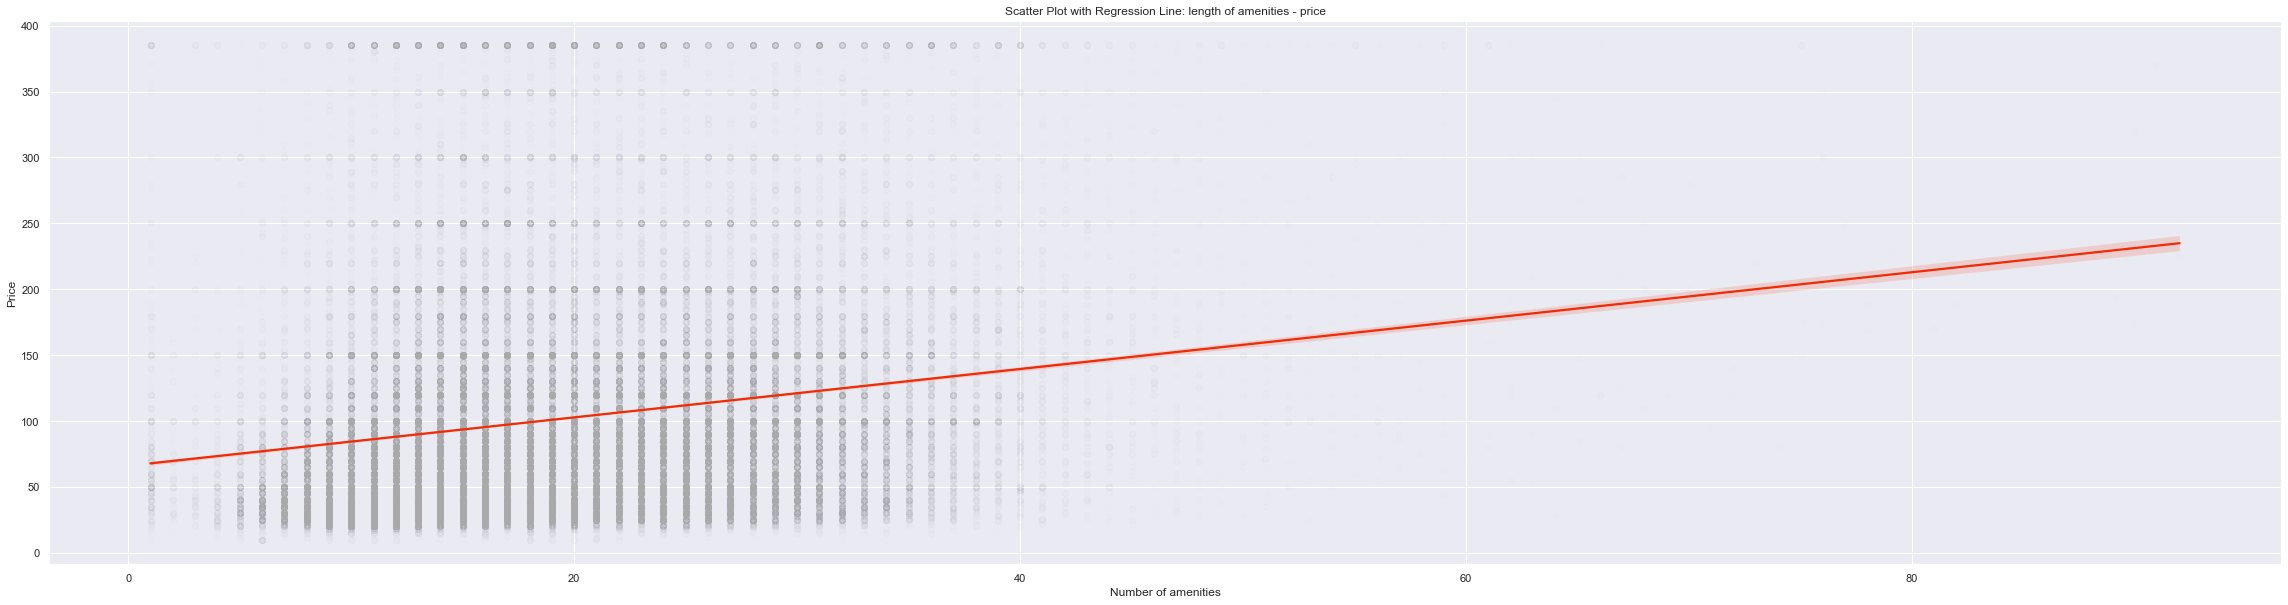

In [280]:
seaborn.regplot(train.len_amenities, train.price,scatter=True, scatter_kws={'color': 'darkgrey', 'alpha':0.01},line_kws={'color':'#F12B04'})
plt.title('Scatter Plot with Regression Line: length of amenities - price')
plt.ylabel('Price')
plt.xlabel('Number of amenities')
plt.show()

There seems to be indeed a noticable relationship between number of offered amenities and price.

## 3.6. Feature Selection

### 3.6.1. Pearson Correlation

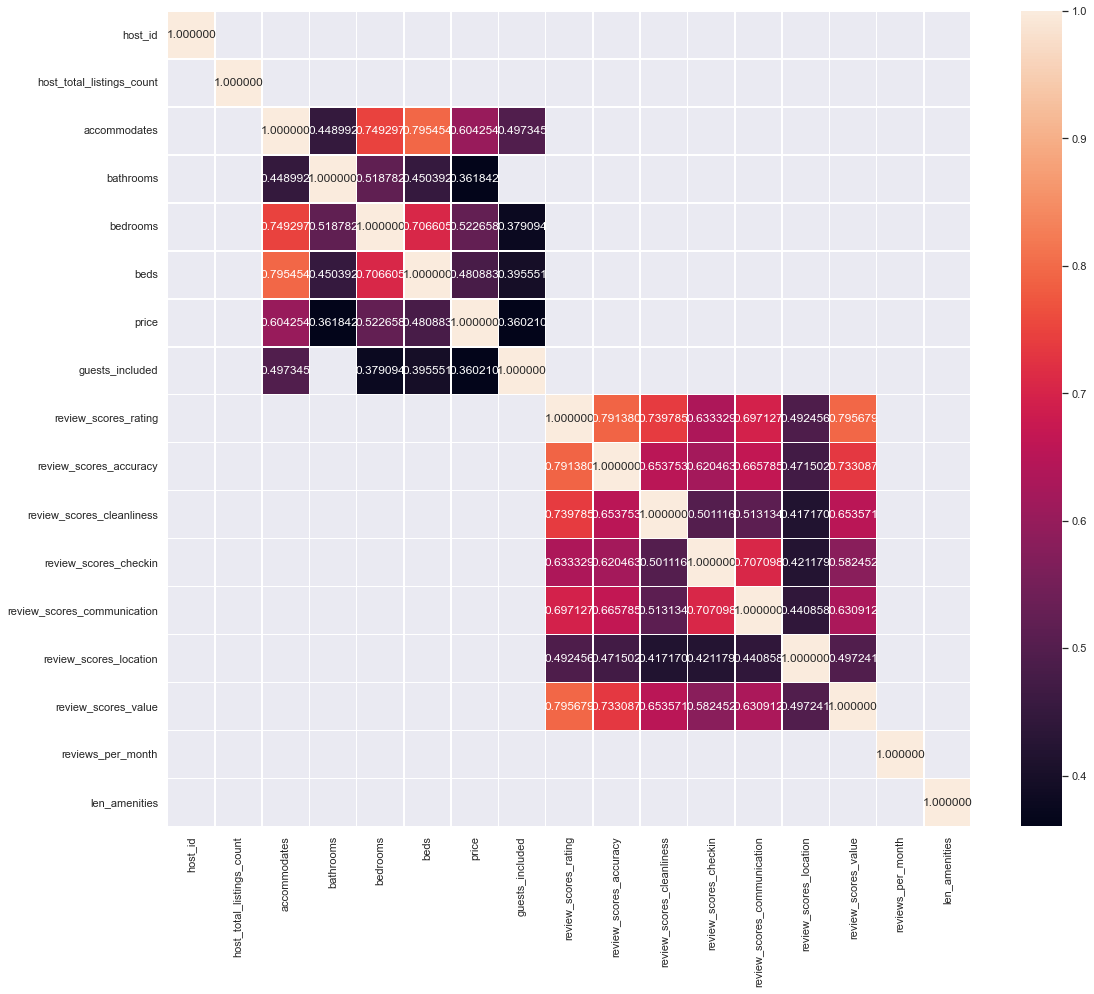

In [192]:
# Correlation heatmap for floats and ints
corr = numeric_columns.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr, 
            annot=True,
            linewidth=.5,
            fmt='1f', 
            mask=(corr<=0.3)); # 0.3 threshold for corelation significance

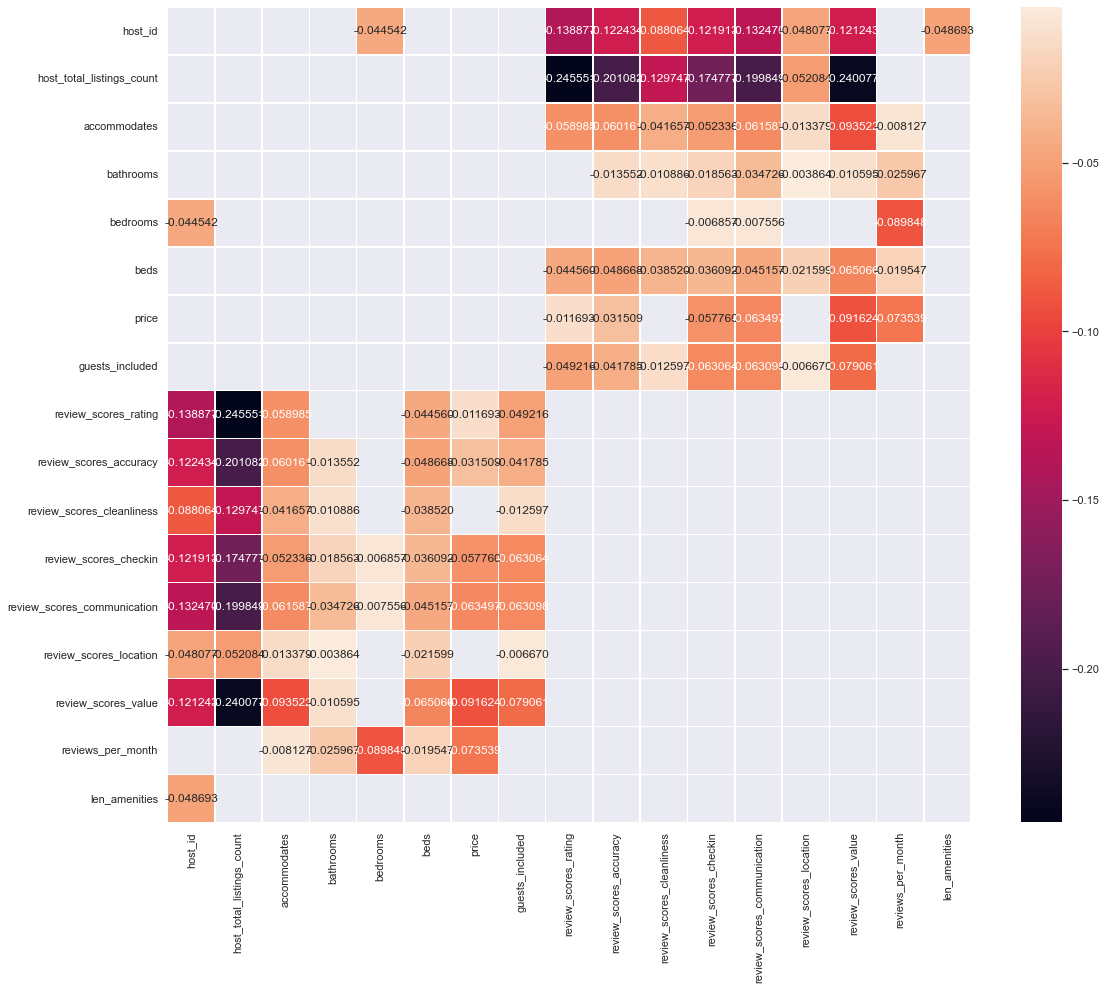

In [193]:
# Check for negative correlation
corr = numeric_columns.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr, 
            annot=True,
            linewidth=.5,
            fmt='1f', 
            mask=(corr>=-0));

Strong correlation price with:
* accommodates
* bedrooms

Medium correlation of price with:
* bathrooms
* beds
* guests_included

No strong negative correlation

In [194]:
# Add price to categorical columns df
categorical_columns_enc_w_price = categorical_columns_enc
categorical_columns_enc_w_price["price"] = train["price"]

As there are a lot of categories in the encoded dataframe, we will need to select the ones with the highest correlation.

In [195]:

corr_w_price_pos = categorical_columns_enc.corr()["price"].sort_values(ascending=False)
corr_w_price_pos[:10]

price                                              1.000
room_type_Entire home/apt                          0.552
neighbourhood_cleansed_Westminster                 0.230
cancellation_policy_strict_14_with_grace_period    0.195
neighbourhood_cleansed_Kensington and Chelsea      0.190
host_response_time_within an hour                  0.103
property_type_Serviced apartment                   0.091
cancellation_policy_super_strict_60                0.084
neighbourhood_cleansed_Camden                      0.081
cancellation_policy_super_strict_30                0.078
Name: price, dtype: float64

In [196]:
corr_w_price_neg = categorical_columns_enc.corr()["price"].sort_values(ascending=True)
corr_w_price_neg[:10]

room_type_Private room                  -0.553
cancellation_policy_flexible            -0.193
host_response_time_not specified        -0.144
neighbourhood_cleansed_Lewisham         -0.080
property_type_House                     -0.075
neighbourhood_cleansed_Croydon          -0.066
neighbourhood_cleansed_Waltham Forest   -0.065
neighbourhood_cleansed_Tower Hamlets    -0.064
room_type_Shared room                   -0.061
neighbourhood_cleansed_Haringey         -0.057
Name: price, dtype: float64

In [197]:
categorical_cols_select = pd.concat([corr_w_price_pos[:10], corr_w_price_neg[:10]]).keys()

In [198]:
categorical_columns_enc[categorical_cols_select]

,price,room_type_Entire home/apt,neighbourhood_cleansed_Westminster,cancellation_policy_strict_14_with_grace_period,neighbourhood_cleansed_Kensington and Chelsea,host_response_time_within an hour,property_type_Serviced apartment,cancellation_policy_super_strict_60,neighbourhood_cleansed_Camden,cancellation_policy_super_strict_30,room_type_Private room,cancellation_policy_flexible,host_response_time_not specified,neighbourhood_cleansed_Lewisham,property_type_House,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Tower Hamlets,room_type_Shared room,neighbourhood_cleansed_Haringey
0,35.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,75.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,120.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
4,104.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55279,65.0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
55280,40.0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
55281,89.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
55282,80.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


<AxesSubplot:>

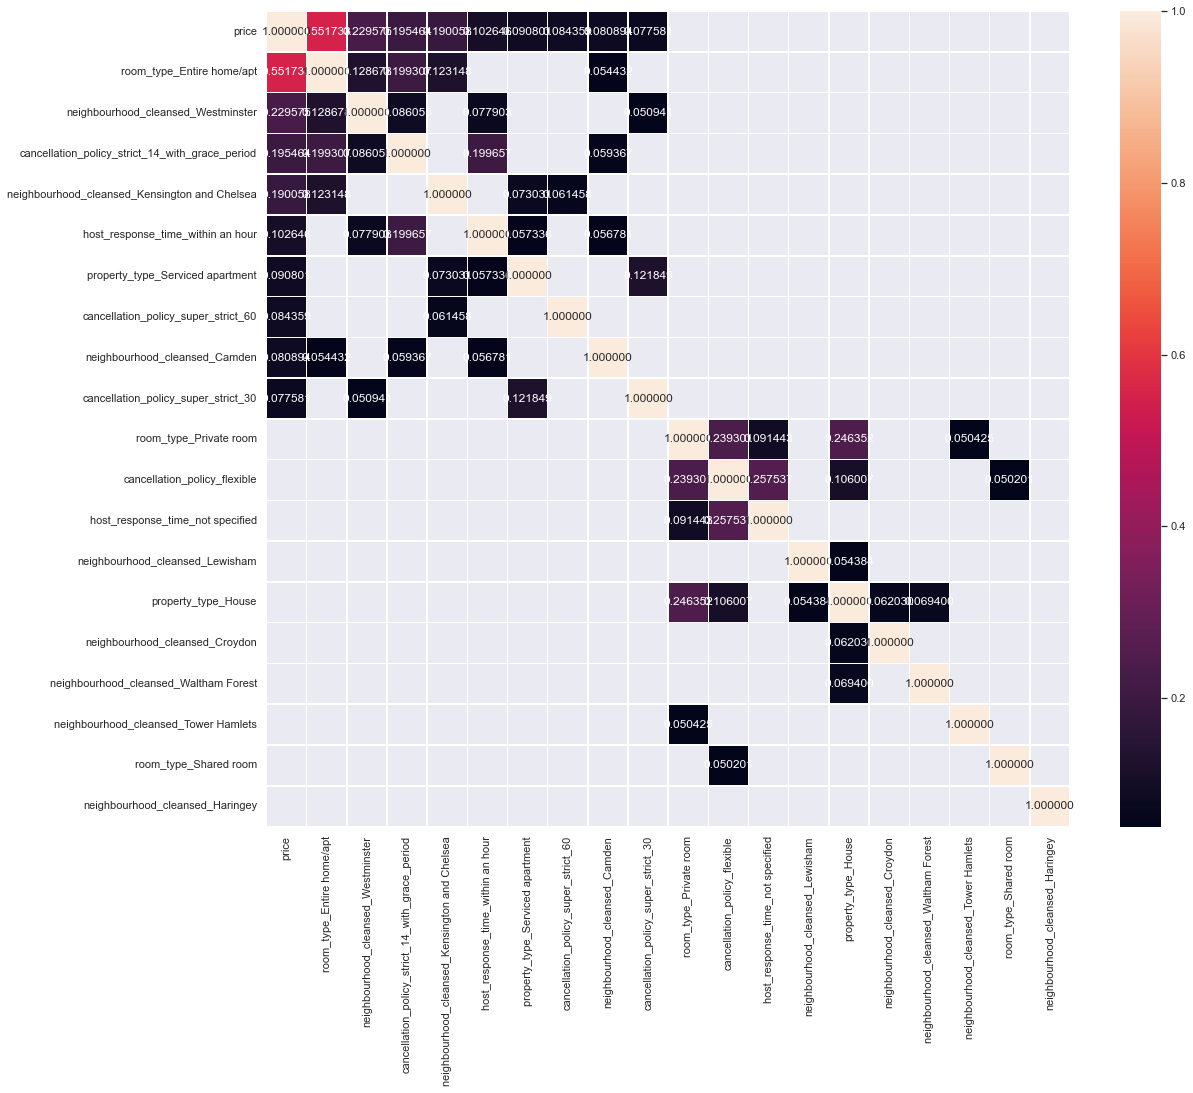

In [199]:
# Correlation heatmap for categorical columns
corr = categorical_columns_enc[categorical_cols_select].corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f'
            ,mask=(corr<=0.05) # setting threshold lower as there does not seem
           )

<AxesSubplot:>

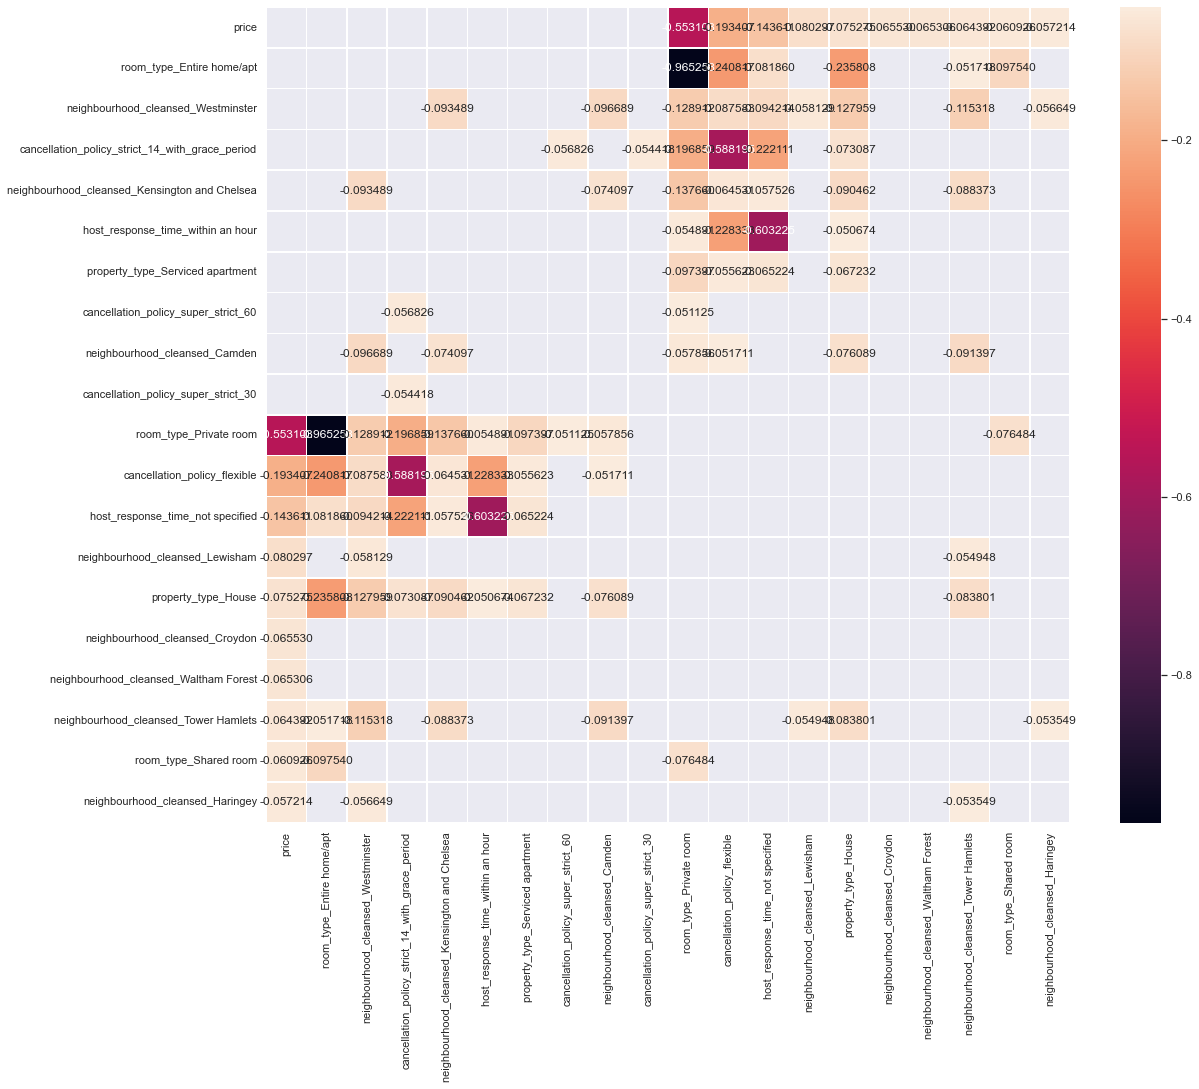

In [200]:
# Correlation heatmap for categorical columns
corr = categorical_columns_enc[categorical_cols_select].corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f'
            ,mask=(corr>(-0.05))
           )

Price has **strong** correlation (|ρ|>0.5)with:
* room_type_Entire home/apt
* Private room (-)

Price has **medium** correlation (0.5>|ρ|>0.3) with no numeric or categorical features.

Price has **low** correlation with (0.3>|ρ|>0) :
* host_response_time_within an hour
* cancellation_policy_string_14_with_grace_period
- neighborhood_cleansed_Westminster

Source: https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/?__cf_chl_jschl_tk__=pmd_.y_GP_QUrkcuo0aU4FG2VAb3YFOX4BPUV6g4enH2RCI-1631283127-0-gqNtZGzNAjujcnBszQe9

Feature selection at this point (nontext):
* accommodates
* bedrooms
* bathrooms
* beds
* guests_included
* room_type_Entire home/apt
* Private room (-)

In [201]:
nontext_features = ["accommodates", "bedrooms", "bathrooms", "beds", "guests_included", "room_type_Entire home/apt", "room_type_Private room"]

## 3.6.2 Fisher Score

In order to make the feature selection process more robust we are going to apply a F-test to our nontext-features as well:

In [202]:
categorical_columns.columns

Index(['experiences_offered', 'host_response_time', 'host_is_superhost',
       'host_has_profile_pic', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bed_type', 'cancellation_policy'],
      dtype='object')

In [203]:
X = categorical_columns_enc.copy()
y = train.price

In [204]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

Wall time: 82.8 ms


In [205]:
X_train.head()

,host_is_superhost,host_has_profile_pic,experiences_offered_business,experiences_offered_family,experiences_offered_none,experiences_offered_romantic,experiences_offered_social,host_response_time_a few days or more,host_response_time_not specified,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Barking and Dagenham,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Plane,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Windmill,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,price
49931,True,True,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,25.0
27072,True,True,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,49.0
10833,True,True,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,240.0
22873,True,True,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,80.0
38090,True,True,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,175.0


In [206]:
f_score = chi2(X_train, y_train)
f_score

(array([1.07733387e-28, 1.07733387e-28, 3.11657924e+02, 9.43965631e+02,
        9.39548865e+00, 4.87519370e+02, 3.00718399e+02, 4.52891844e+02,
        1.19058359e+03, 5.96375884e+02, 4.48268773e+02, 8.47008881e+02,
        2.58967895e+02, 3.58357924e+02, 3.68926249e+02, 5.42982659e+02,
        3.60729079e+02, 1.01003966e+03, 1.38105442e+03, 6.48826383e+02,
        4.84423944e+02, 3.19622268e+02, 3.26446795e+02, 4.73543764e+02,
        6.21248530e+02, 4.63798307e+02, 2.50184720e+02, 5.83201749e+02,
        3.68150081e+02, 2.97508994e+02, 6.79176754e+02, 2.53233822e+03,
        2.74894810e+02, 4.58306007e+02, 5.99671470e+02, 3.73334212e+02,
        5.32583613e+02, 4.52081841e+02, 3.50901015e+02, 4.15196154e+02,
        1.86914524e+02, 6.44166495e+02, 5.92603383e+02, 3.84637962e+02,
        3.18205682e+03, 4.11623947e+02, 9.41111855e+02, 7.06235738e+01,
        2.79429753e+02, 1.87872903e+02, 5.90049314e+02, 1.55939346e+02,
        5.52737500e+03, 7.99134709e+01, 2.41900186e+02, 2.588571

First we take a look at the p-values:

In [207]:
p_values = pd.Series(f_score[1], index=X_train.columns)
p_values.sort_values(ascending=True, inplace=True)
p_values

price                                  0.0
property_type_House                    0.0
property_type_Bus                      0.0
room_type_Entire home/apt              0.0
cancellation_policy_super_strict_60    0.0
                                      ... 
property_type_Bungalow                 1.0
host_is_superhost                      1.0
property_type_Farm stay                NaN
property_type_Parking Space            NaN
property_type_Windmill                 NaN
Length: 101, dtype: float64

<AxesSubplot:>

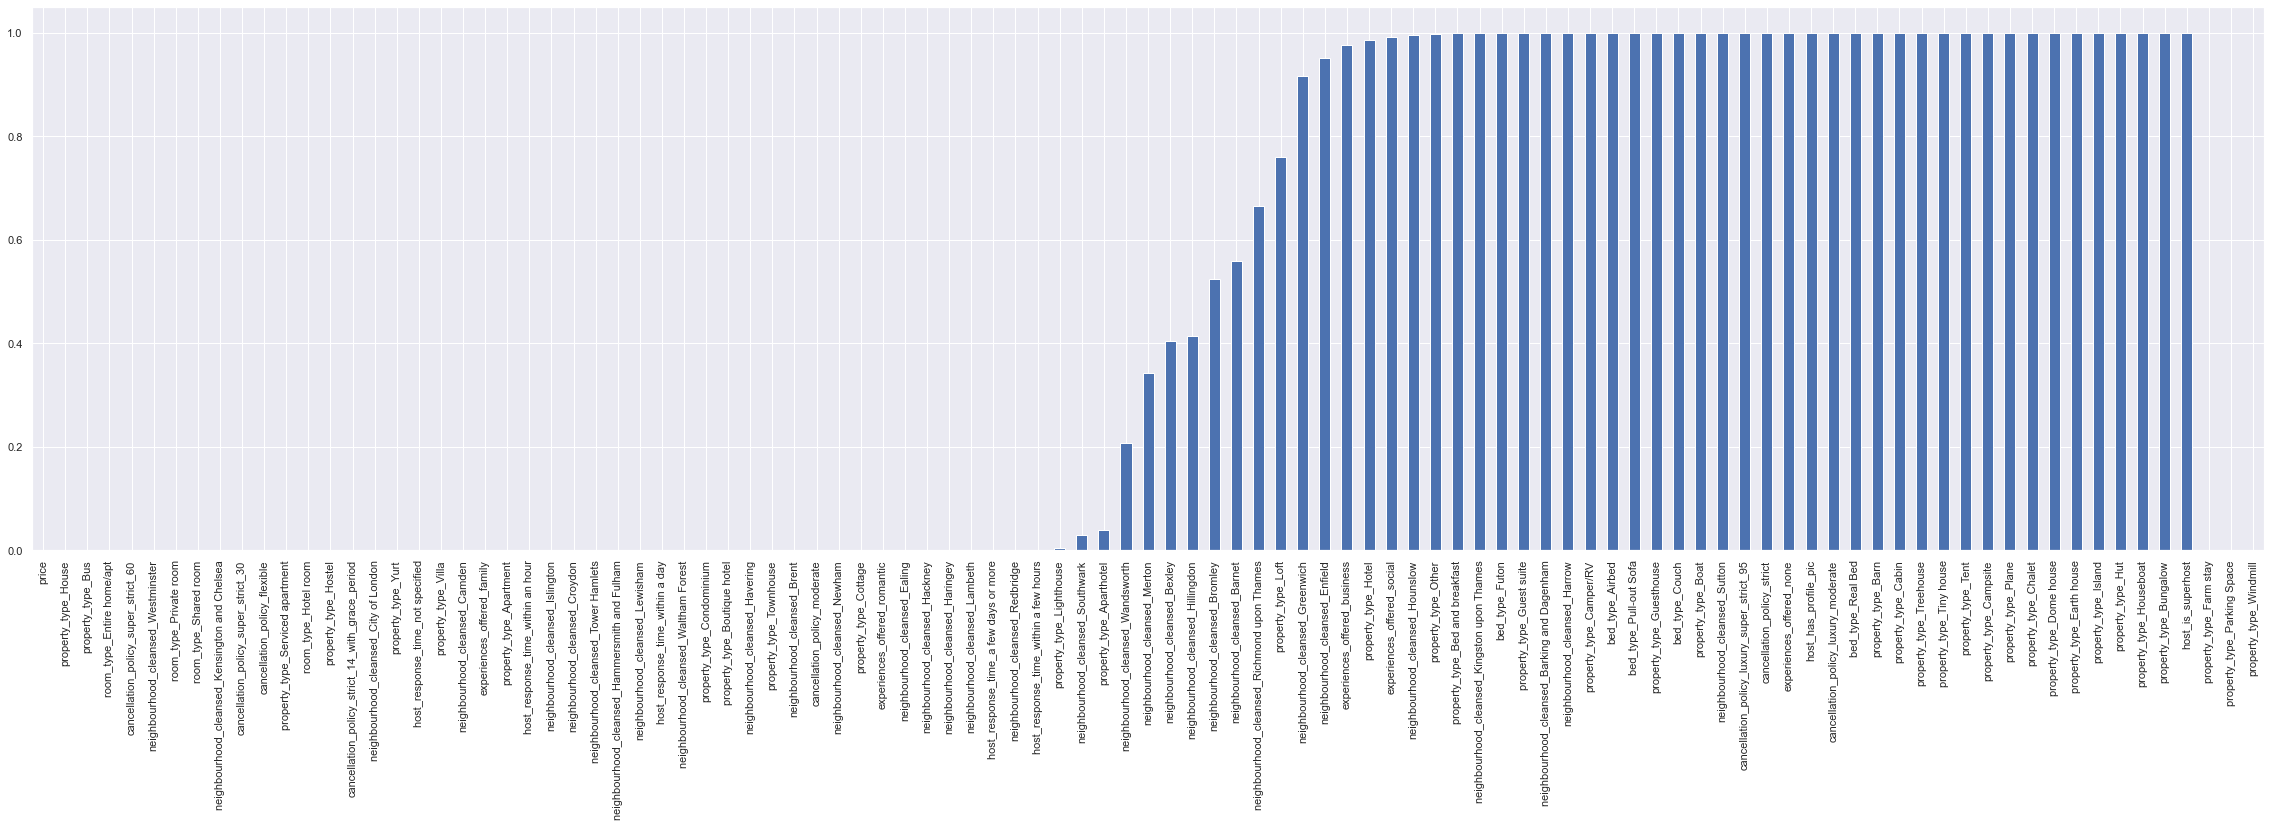

In [208]:
p_values.plot.bar()

Most important feats: with low F score:
- room_type_Shared room                               0.000e+00
- cancellation_policy_super_strict_60                 0.000e+00
- room_type_Private room                              0.000e+00
- room_type_Entire home/apt                           0.000e+00

This confirms our feature selection for room_type_Private room, room_type_Entire home/apt

_Regarding remaining features_: Due to limitation of computational resources, we will not be using feature url for the analysis, as well as latitute and longitude. In addition, ``neighborhood`` feature was not used as `neighborhood_cleansed` was enough for the analyis.

#### Save dataset in current from in hard drive

In [209]:
with open('train.pkl', 'wb') as file_name:
    pickle.dump(train, file_name)
with open('test.pkl', 'wb') as file_name:
    pickle.dump(test, file_name)

---

# 4. Data Preparation (Text Features - NLP)

---

## 4.1. Text Cleaning

In order to extract value from the text features in the datast, we are going to clean them and bring them to a form appropriate for analysis and model training. To this end, we are going to use the cleaning process defined in supporting file "text_cleaning.py" to determine what part of speech (POS) each word in text is, as well as transform text appropriately:
To be applied to the following features:
* name
* summary
* space
* description
* neighborhood_overview
* transit
* house_rules

In [210]:
text_features = ["name", "summary", "space", "description", "neighborhood_overview", "transit", "house_rules"]

#### Cleaning function

The following operations are applied in the text features:
* remove html content
* remove non-alphanumeric characters
* tokenization
* remove stopwords
* lemmatization
* detokenization
* remove duplicate consecutive letters

In [211]:
def clean_text_column(column, no_of_lines=100000):
    """ NLP cleaning function. Steps applied:
        - Removal of html tags
        - Removal of non-alphanumeric characters
        - Removal of stopwords.
        - Lemmatization based on POS tag (determind using WordNet) 
    """
    text_column = []

    lemmatizer = WordNetLemmatizer()
    
    if no_of_lines == 100000:
        no_of_lines = len(column)
        
    print('*' * 40)
    print('Cleaning {}'.format(no_of_lines), 'out of {} lines of text column.'.format(column.shape[0]))
    counter = 0
    for text in column:
        
        # remove html content
        text_column_text = BeautifulSoup(text).get_text()
        
        # remove non-alphabetic characters
        text_column_text = re.sub("[^a-zA-Z]"," ", text_column_text)
    
        # tokenize the sentences
        words = word_tokenize(text_column_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
        
        text_column.append(lemma_words)
              
        if (counter > 0 and counter % 5000 == 0):
            print('Processed {} lines of text column'.format(counter))
            
        counter += 1
        
        # breakpoint to test for specific number of lines
        if counter==no_of_lines:
            break
        
    print('DONE')
    print('*' * 40)

    return(text_column)

In [212]:
# Detokenization function
def detokenizing(series):
        detokenized = [TreebankWordDetokenizer().detokenize(text) for text in text_feats_train[feature]]
        out_df = pd.Series(detokenized, index=text_feats_train.index, dtype="str")
        text_feats_train[feature] = out_df

In [213]:
# Functoin to remove more than 2 duplicate consecutive letteres
def reduce_lengthening(text):
    # https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

all tranformations are applied by running script file "text_cleaning.py". The **result** of all above mentioned tranformations can be loaded with the following .pkl files:

In [214]:
# load cleaned data from disk
with open('train_text_cols_clean.pkl', 'rb') as file_name:
    train_text_cols_clean = pickle.load(file_name)
with open('test_text_cols_clean.pkl', 'rb') as file_name:
    test_text_cols_clean =pickle.load(file_name)

In [215]:
train_text_cols_clean.shape

(55284, 7)

In [216]:
train[text_features].shape

(55284, 7)

Assigning clean text columns to train and test set:

In [217]:
train[text_features] = train_text_cols_clean
test[text_features] = test_text_cols_clean

We can take a look a the output:

In [218]:
train_text_cols_clean.head()

,name,summary,space,description,neighborhood_overview,transit,house_rules
0,attic room historic greenwich,room door discreet staircase light airy open p...,double room available historic royal greenwich...,room door discreet staircase light airy open p...,,parking restrict london visitor parking permit...,shoe carpet food attic room guest invite back ...
1,lovely garden studio private access,garden studio private entrance minute crouch e...,beautiful studio king size bed sofa coffee tab...,garden studio private entrance minute crouch e...,crouch end hip friendly neighbourhood fill end...,walk across street w bus stop finsbury park un...,love would remove shoe door help keep garden r...
2,comfi apartment close wimbledon tennis court,,,,,,party event allow smoking inside property addi...
3,luxury room heart london sw,luxury first floor victorian split level maiso...,room fully furnish include double bed mirror w...,luxury first floor victorian split level maiso...,gail coffee shop round corner well local indep...,happy advise thing london local area flat loca...,check pm later pm week day shoe house drink fo...
4,excellent city apartment private patio,new luxury apartment private outside patio gre...,modern well equip cosy apartment close victori...,new luxury apartment private outside patio gre...,,,happy visit please care respect apartment leav...


In [219]:
test_text_cols_clean.head()

,name,summary,space,description,neighborhood_overview,transit,house_rules
0,ladbroke grove stylish portobello apartment,large bright contemporary flat locate heart la...,,large bright contemporary flat locate heart la...,,,
1,contemporary design notting hill,stylish design beautiful tree line street nott...,phone number hidden airbnb thoughtfully design...,stylish design beautiful tree line street nott...,notting hill trendy artistic bohemian neighbou...,underground station within walk distance westb...,
2,en suite double bedroom,quiet en suite double bedroom lovely house cam...,,quiet en suite double bedroom lovely house cam...,,,
3,double room balcony magnificent penthouse,place close aldgate love place view location a...,,place close aldgate love place view location a...,,,party event guest
4,bockery suite chelsea,suite comprises bedroom bathroom excellent bal...,whether family whether need accommodation busi...,suite comprises bedroom bathroom excellent bal...,fill relax peace comfort room take trip discov...,visitor often tell u idea well connect transpo...,privacy room business long harm disturb others...


## 4.2. Most used words

we want to analyze the cleaned text features for keywords that predict a higher price by themselves.

first look at the most used words in the **top 5% listings** of the train data with respect to price (top 5% most expensive listings)

In [220]:
topfiveperc_value = np.percentile(train.price,95,interpolation="higher")
topfiveperc_ix = train.index[np.where(train.price>topfiveperc_value)]

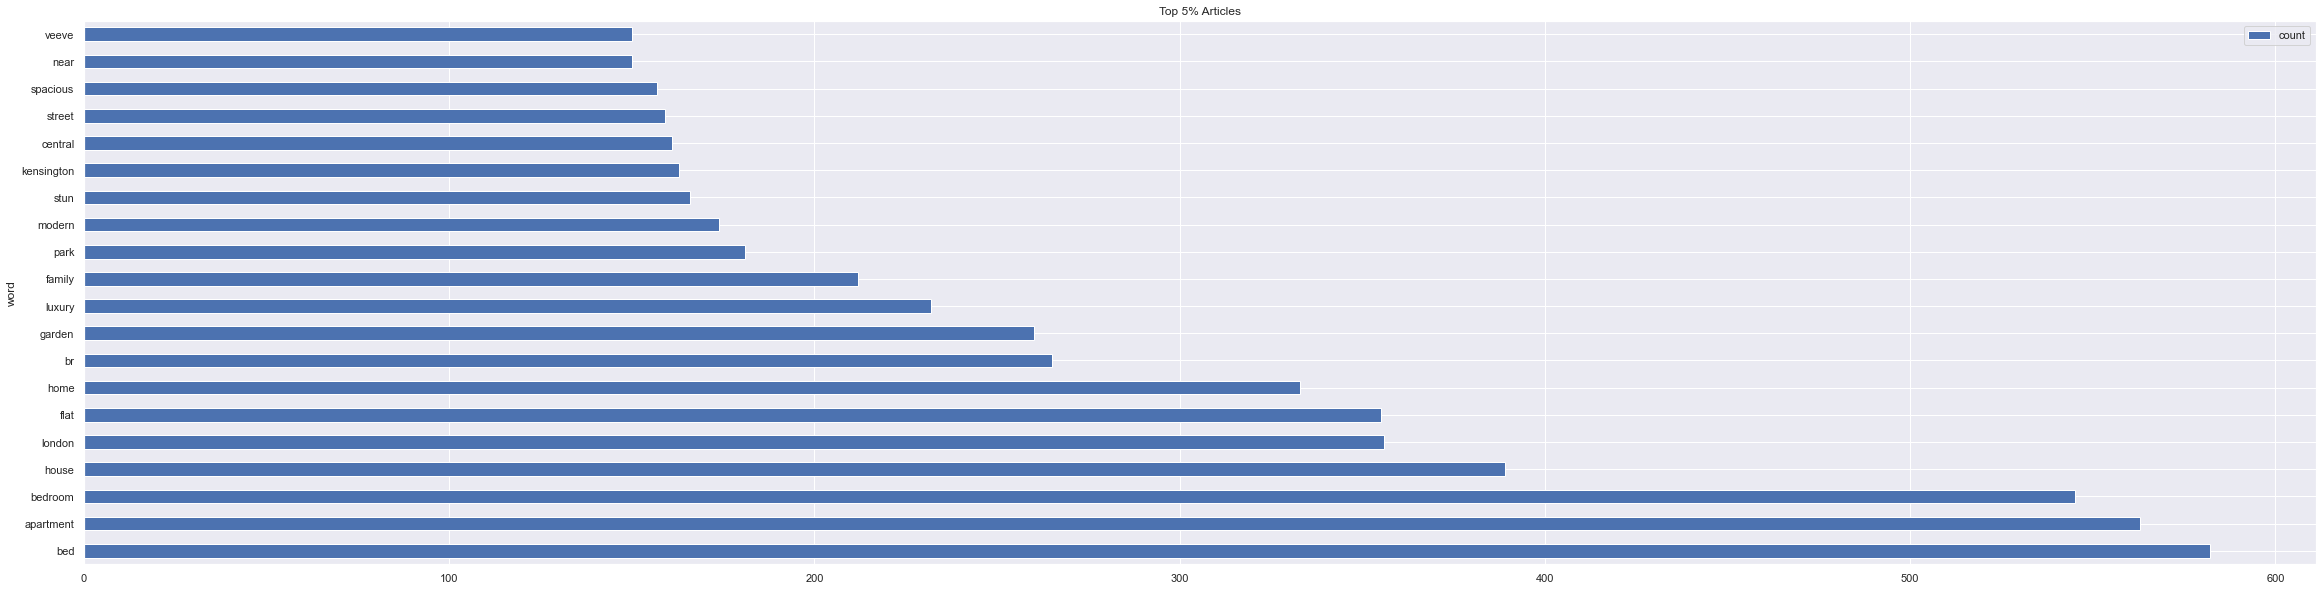

In [221]:
# top 5% percent listings with highest price
split_it = train.name[topfiveperc_ix].apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for ele in split_it:
    for word, count in ele:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="Top 5% Articles");

To get a sense of which words stand out we can apply the same funciton for the top 50% of the data:

In [222]:
topfiveperc_value = np.percentile(train.price,50,interpolation="higher")
topfiveperc_ix = train.index[np.where(train.price>topfiveperc_value)]

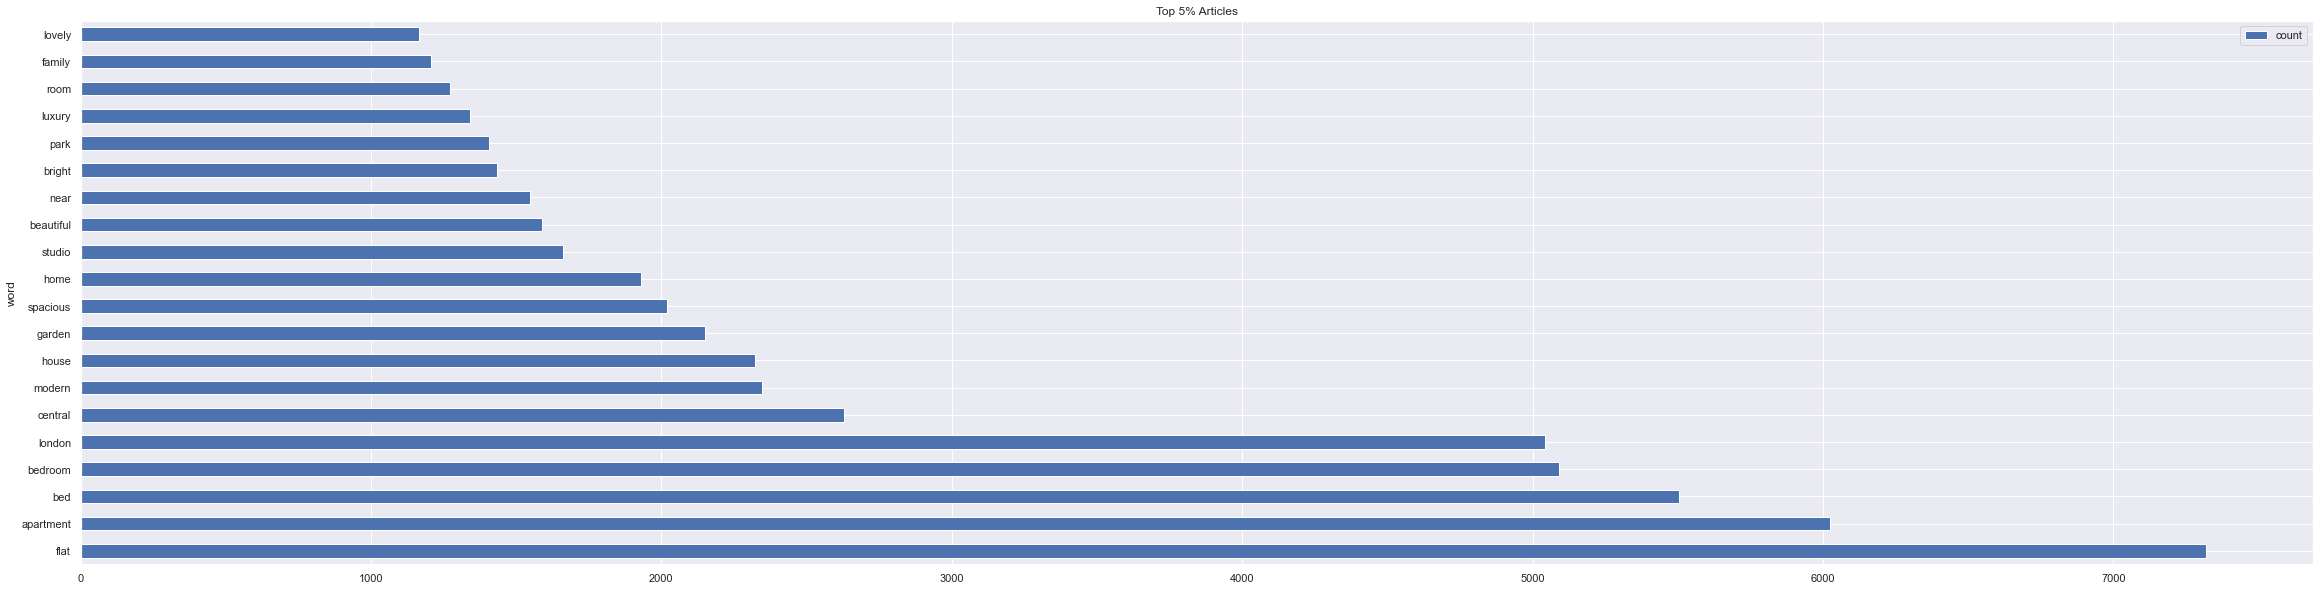

In [223]:
# top 5% percent listings with highest price
split_it = train.name[topfiveperc_ix].apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for ele in split_it:
    for word, count in ele:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="Top 5% Articles");

In [224]:
# assigning top 20 words of 5% most expensive to list
top_20_words = list(counts_df.sort_values(by="count",ascending=False)[:20].word)

In [225]:
# Lowest 5%
bottomfiveperc_value = np.percentile(train.price,5,interpolation="lower")
bottomfiveperc_ix = train.index[np.where(train.price<=bottomfiveperc_value)]

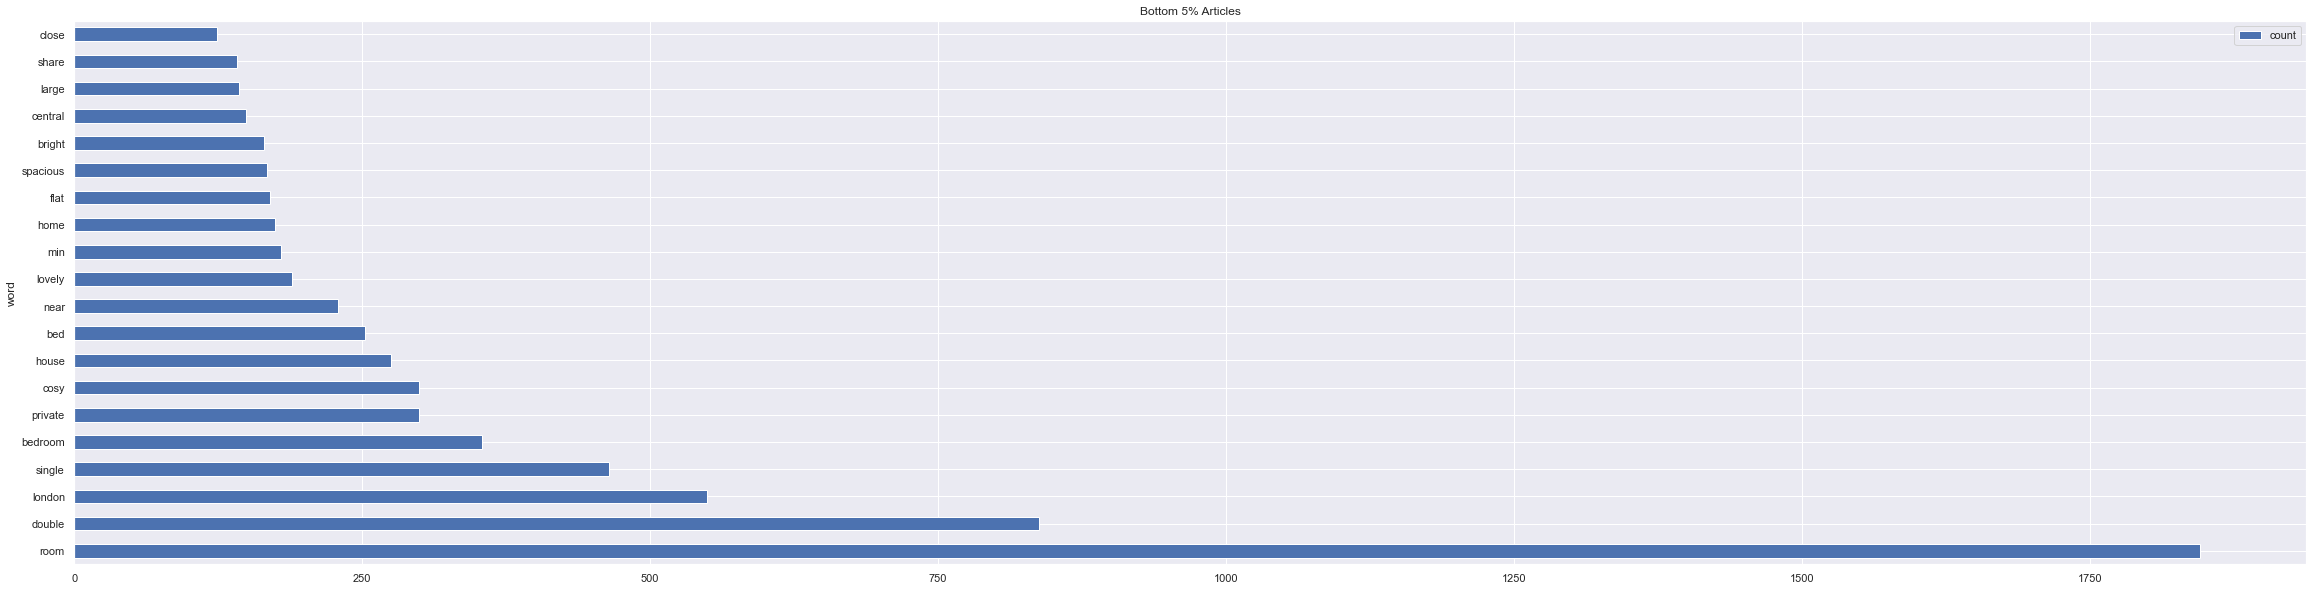

In [226]:
split_it = train.name[bottomfiveperc_ix].apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for ele in split_it:
    for word, count in ele:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="Bottom 5% Articles");

## 4.3. Sentiment Analysis

Sentiment analysis is useful for analysing text, specifically whether it is rather positive or rather negative. Since user input is available in airbnb listings in the form of review, this additional text data will be used to determine if additional information can be mined.

#### Import reviews file

In [227]:
from nltk.sentiment import SentimentIntensityAnalyzer

reviews = pd.read_csv(PATH + "reviews.csv")
reviews.head()

,reviewer_id,comments,review_id,listing_id
0,93896,"The flat was bright, comfortable and clean and...",30672,8Z94Z3WMCO
1,97890,We stayed with Adriano and Valerio for a week ...,32236,8Z94Z3WMCO
2,104133,Adriano was a fantastic host. We felt very at ...,41044,8Z94Z3WMCO
3,122714,We had a most wonderful stay with Adriano and ...,48926,8Z94Z3WMCO
4,111543,I'm not sure which of us misunderstood the s...,58352,8Z94Z3WMCO


The following operations are done via helping file "sentiment_analysis.py":
- Calculate polarity score for each review
- Save polarity score as "pos_score" in file "sentiment_analysis.pkl"

Calculate sentiment score 0-1 for each review 

In [228]:
# loading sentiment analysis score from pkl file
pos_scores = pickle.load(open("sentiment_analysis.pkl", "rb"))
len(pos_scores)

1540778

In [229]:
reviews["pos_score"] = pos_scores
reviews.head()

,reviewer_id,comments,review_id,listing_id,pos_score
0,93896,"The flat was bright, comfortable and clean and...",30672,8Z94Z3WMCO,0.269
1,97890,We stayed with Adriano and Valerio for a week ...,32236,8Z94Z3WMCO,0.248
2,104133,Adriano was a fantastic host. We felt very at ...,41044,8Z94Z3WMCO,0.226
3,122714,We had a most wonderful stay with Adriano and ...,48926,8Z94Z3WMCO,0.192
4,111543,I'm not sure which of us misunderstood the s...,58352,8Z94Z3WMCO,0.115


Merge pos_score with train dataset

We keep only the positive score to join to our train dataset. Then we calculate the mean for each listing:

In [230]:
reviews.drop(columns=["reviewer_id", "review_id", "comments"], inplace=True)

In [231]:
reviews = reviews.groupby("listing_id").mean()
reviews

,pos_score
listing_id,
000MYWWTZG,0.329
001C3U2AUM,0.435
001HI2QWG0,0.295
001PH5SROS,0.327
001W9P1318,0.330
...,...
ZZXN33VP5O,0.290
ZZYFC9JCU5,0.326
ZZYO6N3BWX,0.397


In [232]:
train = pd.merge(train, reviews, on="listing_id", how="left")
train.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id,experiences_offered_business,experiences_offered_family,experiences_offered_none,experiences_offered_romantic,experiences_offered_social,host_response_time_a few days or more,host_response_time_not specified,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Barking and Dagenham,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Campsite,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Plane,property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Windmill,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,host_days,len_amenities,pos_score
0,attic room historic greenwich,room door discreet staircase light airy open p...,double room available historic royal greenwich...,room door discreet staircase light airy open p...,business,,parking restrict london visitor parking permit...,shoe carpet food attic room guest invite back ...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,2012-04-18,within an hour,1.0,True,1.0,True,True,Greenwich,Greenwich,SE10 8SX,51.475,-0.011,Townhouse,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"[Wifi, Paid parking off premises, Heating, Was...",35.0,1,95.0,10.0,10

Check pos_score correlation with price

In [233]:
train.price.corr(train.pos_score)

-0.022068985032963208

As this first application of sentiment analysis does not seem to offer much predictive value, we are not going to further purse this feature or include it in the subsequent analysis.

## 4.4. Preparation for text feature selection

### 4.4.1 Import pre-trained word2vec embeddings

After research and testing it was concluded that: "...pre-trained word embeddings lead to a faster training and a lower final training loss..." and "...vectors trained on a large corpus beat the embedding layer by a considerable margin, in terms of both precision and recall..." (Source: https://towardsdatascience.com/pre-trained-word-embeddings-or-embedding-layer-a-dilemma-8406959fd76c)

We will be selecting **pre-trained embeddings** in word2vec format, trained on a **large corpus**. For this reason we will be selecting embeddings trained on 100d wikipedia data (Source: https://wikipedia2vec.github.io/wikipedia2vec/pretrained/)


In [235]:
wiki2vec = KeyedVectors.load_word2vec_format("enwiki_20180420_100d.txt")

In [236]:
# Check for similar words
wiki2vec.most_similar("bedroom")

[('upstairs', 0.8561639785766602),
 ('bathroom', 0.825106143951416),
 ('bedrooms', 0.8194072246551514),
 ('room', 0.8144454956054688),
 ('apartment', 0.7999701499938965),
 ('downstairs', 0.7994751334190369),
 ('coatroom', 0.7776296138763428),
 ('bedsitting', 0.7727512717247009),
 ('motel', 0.7629930973052979),
 ('kitchen', 0.7576059699058533)]

In [237]:
# Check for phrases
wiki2vec.most_similar("ENTITY/London")

[('london', 0.7430475354194641),
 ('ENTITY/Lambeth', 0.6579214930534363),
 ('ENTITY/North_London', 0.650565505027771),
 ('ENTITY/Paris', 0.6440966129302979),
 ('ENTITY/Tokyo', 0.6433696746826172),
 ('ENTITY/Paddington', 0.6414259076118469),
 ('ENTITY/History_of_London', 0.632715106010437),
 ('ENTITY/Timeline_of_London', 0.6307928562164307),
 ('ENTITY/Central_London', 0.6293672919273376),
 ('harlesden', 0.627341628074646)]

### 4.4.2. Embedding matrix, encode and sequence padding

#### Function to construct embedding matrix

In [239]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''
        Helper function to construct an embedding matrix for
        the focal corpus based on some pre-trained embeddings.
    '''

    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))

    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding.
    # In this case we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    for word, i in tokenizer.word_index.items():
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return emb_mat, oov_words

Drawback of word2vec format is that there is no quick way to handle OOV words

## 4.5. Text feature selection

To get a sense of which text featues hold the most predictive power we are going to apply each of them separately a simple GRU network setup, as GRU networks train generally faster. Due to restrictions in processing power we will be training for 5 epochs, just enough to get a sense of the predictive power of each text feature. For sake of brevity code below only shows for first text feature (name) to show the model setup.

In [240]:
# Split text features
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(train[text_features], # X
                                                                        train.price, # y
                                                                        test_size=0.3, random_state=0)

print(X_train_text.shape, X_test_text.shape, y_train_text.shape, y_test_text.shape)

(38698, 7) (16586, 7) (38698,) (16586,)


In [241]:
# Function to create embedding matrix
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''
        Helper function to construct an embedding matrix for
        the focal corpus based on some pre-trained embeddings.
    '''

    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))

    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding.
    # In this case we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    for word, i in tokenizer.word_index.items():
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return emb_mat, oov_words

In [ ]:
column = "name"

#######################################################################
tokenizer_col = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_col.fit_on_texts(X_train_text[column])
NUM_WORDS_COL = len(tokenizer_col.word_index) + 1

X_tr_int_col = tokenizer_col.texts_to_sequences(X_train_text[column])
max_col_length = max([len(text) for text in X_tr_int_col])
print('The longest name of the training set has {} words.'.format(max_col_length))

# Upper bound of the article length for padding
MAX_COL_LENGTH = max_col_length
print(MAX_COL_LENGTH)

X_tr_int_pad_col = pad_sequences(X_tr_int_col, MAX_COL_LENGTH)

# Encode and pad the test data
X_ts_int_col = tokenizer_col.texts_to_sequences(X_test_text[column])
X_ts_int_pad_col = pad_sequences(X_ts_int_col, MAX_COL_LENGTH)

wiki_weights_col, _ = get_embedding_matrix(tokenizer_col, wiki2vec, NUM_WORDS_COL)

#######################################################################
# train network
input_col= Input(shape=(MAX_COL_LENGTH, ))

# Title
col_embeddings = Embedding(input_dim=NUM_WORDS_COL, 
                            output_dim=100,
                            embeddings_initializer=Constant(wiki_weights_col),
                            input_length=MAX_COL_LENGTH)(input_col)
GRU_col = GRU(100)(col_embeddings)
dense_col = Dense(1, activation="relu")(GRU_col)

model = Model(inputs=input_col, 
              outputs=dense_col) 

model.compile(loss=losses.LogCosh(), 
              optimizer="adam", 
              metrics=["mae", "mse"])

print(model.summary())
callbacks = [EarlyStopping(monitor="val_loss", 
                           patience=3, 
                           verbose=1, 
                           min_delta=0.1, 
                           restore_best_weights=True)]

story = model.fit(X_tr_int_pad_col, 
                  y_train_text, 
                  epochs=5,
                  verbose=1, batch_size=256,
                  validation_split=0.2, 
                  callbacks=callbacks)

#######################################################################
preds = pd.DataFrame(model.predict(X_ts_int_pad_col), columns=[column], index=y_test_text.index)
preds["actual"] = y_test_text
print(f"Text MSE: {mean_squared_error(preds[column], preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds[column], preds.actual)}\n")


After passing all text features through this simple GRU setup with 5 epochs we see that the features that hold the most predictive value based on MSE and MAE are:
- name
- neighborhood_overview

In [243]:
text_features = ['name', 'neighborhood_overview']

---

# 5. Model training and selection

---

In order to train and make predictions with our text and nontext data we are going to experiment with different types of Recurrent Neural Networkds (RNN). We decide for a RNN setup as RNNs can use their internal state (memory) to process sequences of inputs, which is suitable for our text data. It is an ideal setup for sequential data or data with temporal relationship. As a metric of accuracy we are going to use mean average error and mean squared error, which are standard metrics for regression.

## 5.1. Train non-text models for benchmarking

From EDA in part 2 we have selected the following non-text features:

In [244]:
nontext_features

['accommodates',
 'bedrooms',
 'bathrooms',
 'beds',
 'guests_included',
 'room_type_Entire home/apt',
 'room_type_Private room']

The first model we will use for benchmarking for nontext features is linear regression

#### Split nontext features of train dataset

In [245]:
X_train_nontext, X_test_nontext, y_train_nontext, y_test_nontext = train_test_split(train[nontext_features], # X
                                                                        train.price, # y
                                                                        test_size=0.3, random_state=0)

print(X_train_nontext.shape, X_test_nontext.shape, y_train_nontext.shape, y_test_nontext.shape)

(38698, 7) (16586, 7) (38698,) (16586,)


We get some null values for train dataset after splitting, so we fill them in:

In [ ]:
X_train_nontext.bathrooms.fillna(X_train_nontext.bathrooms.median(), inplace=True)
X_test_nontext.bedrooms.fillna(X_test_nontext.bathrooms.median(), inplace=True)
X_test_nontext.bes.fillna(X_test_nontext.bathrooms.median(), inplace=True)
X_train_nontext.isnull().sum()

### 5.1.1. Linear Regression

In [ ]:
# Evaluate predictions (R2, p-values)
est = sm.OLS(y_train_nontext, X_train_nontext)
est2 = est.fit()
print(est2.summary(), end = "\n\n")

# Train model
model = LinearRegression(fit_intercept = False)
# print(model, end = "\n\n")
model.fit(X_train_nontext, y_train_nontext) # OLS

# Create predictions
X_pred = X_test_nontext
y_pred = model.predict(X_pred)

# MAE
MAE = metrics.mean_absolute_error(y_test_nontext, y_pred)
print("Mean Absolute Error:", round(MAE, 2), end = "\n\n")

# MSE
MSE = metrics.mean_squared_error(y_test_nontext, y_pred)
print("Mean Squared Error:", round(MSE, 2), end = "\n\n")


We already get good accuracy from the linear regression model. In addition a p-value of 0 (<0.05) for all variables shows that Rsquared is statistically significant. Also F-value of 2.2 (>1) shows there is a strong relationship between features and target variable. Overall we confirm our findings from EDA part.

### 5.1.2. Random Forest

Second model we will use for benchmarking the performance of nontext features is random forest. We will insert the same nontext features in the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
train[nontext_features].bathrooms.fillna(train[nontext_features].bathrooms.median(), inplace=True)
train[nontext_features].isnull().sum()

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(train[nontext_features], train['price'], test_size=0.20, random_state=0)

rf = RandomForestRegressor(n_estimators=1000, max_depth = None
                           , random_state=0, verbose=1, n_jobs=10)
rf.fit(X_train, y_train)

prediction = pd.DataFrame({"Prediction": rf.predict(X_test), "Actual": y_test})

print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

We get a good result with random forest as well, which confirms our expectation that nontext features hold significant predictive power.

## 5.2. RNN architecture selection

In order to decide which neural network model setup best suits the needs of our predictive task we are going to try different netowrk architecturs for a low number of epochs and standard hyperparameter settings (optimizer=adam) to get a sense which setup has the most potential for accurate predictions. The reason for selectiong and LSTM architecture is that LSTMs are good for process and make predictions given sequences of data. In addition, LSTMs provide us with a large range of parameters such as learning rates, and input and output biases. The following model architectures will be tried:
* GRU
* LSTM
* Bidirectional LSTM

for our predictive task we will be setting up an sequential models. architecture network. The reason for selectiong and LSTM architecture is that LSTMs are good for process and make predictions given sequences of data. In addition, LSTMs provide us with a large range of parameters such as learning rates, and input and output biases

First choice for number of neurons for the hidden layer is determined to be 100, which might be adjusted later during hyperparameter tuning.

#### Embedding matrix for name

In [259]:
tokenizer_title = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_title.fit_on_texts(X_train_text.name)
NUM_WORDS_TITLE = len(tokenizer_title.word_index) + 1

X_tr_int_title = tokenizer_title.texts_to_sequences(X_train_text.name)
max_article_length = max([len(article) for article in X_tr_int_title])
print('The longest name of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TITLE_LENGTH = 50
X_tr_int_pad_title = pad_sequences(X_tr_int_title, MAX_TITLE_LENGTH)

# Encode and pad the test data
X_ts_int_title = tokenizer_title.texts_to_sequences(X_test_text.name)
X_ts_int_pad_title = pad_sequences(X_ts_int_title, MAX_TITLE_LENGTH)

wiki_weights_title, _ = get_embedding_matrix(tokenizer_title, wiki2vec, NUM_WORDS_TITLE)

The longest name of the training set has 30 words.
Created embedding matrix of shape (5236, 100)
Encountered 720 out-of-vocabulary words.


#### Embedding matrix for neighborhood_overview

In [260]:
tokenizer_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_text.fit_on_texts(X_train_text.neighborhood_overview)
NUM_WORDS_TEXT = len(tokenizer_text.word_index) + 1

X_tr_int_text = tokenizer_text.texts_to_sequences(X_train_text.neighborhood_overview)
max_article_length = max([len(article) for article in X_tr_int_text])
print('The longest text of the training set has {} words.'.format(max_article_length))

# Upper bound of the text length for padding
MAX_TEXT_LENGTH = 250
X_tr_int_pad_text = pad_sequences(X_tr_int_text, MAX_TEXT_LENGTH)

# Encode and pad the test data
X_ts_int_text = tokenizer_text.texts_to_sequences(X_test_text.neighborhood_overview)
X_ts_int_pad_text = pad_sequences(X_ts_int_text, MAX_TEXT_LENGTH)

wiki_weights_text, _ = get_embedding_matrix(tokenizer_text, wiki2vec, NUM_WORDS_TEXT)

The longest text of the training set has 191 words.
Created embedding matrix of shape (17182, 100)
Encountered 1949 out-of-vocabulary words.


### 5.2.1. GRU

We will start with a GRU network, which we also used for feature selection for the text features. The GRU (Gated Recurrent Unit) has the advantage of being comparable to an LSTM in terms of performance, while being computationally more efficient. This makes for a good candidate for a model for our predictive task.

In [ ]:
# Scaling the data to the interval [0,1] to avoid NAN loss in Keras
# Since all values in our nontext features are >0, we scale in interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X_train_nontext)
X_train_nontext_scale = scaler.transform(X_train_nontext)
X_train_nontext_scale

In [ ]:
input_text = Input(shape=(250, ))
input_title = Input(shape=(50, ))
input_nontext = Input(shape=(7, ))

# Text
text_embeddings = Embedding(input_dim=NUM_WORDS_TEXT, 
                            output_dim=100,
                            embeddings_initializer=Constant(wiki_weights_text), 
                            input_length=250)(input_text)
GRU_text = GRU(100)(text_embeddings)
dense_text = Dense(1,
                   activation="relu", 
#                    kernel_regularizer=regularizers.l2(0.01), 
                   )(GRU_text)

# Title
title_embeddings = Embedding(input_dim=NUM_WORDS_TITLE, 
                             output_dim=100, 
                             embeddings_initializer=Constant(wiki_weights_title), 
                             input_length=50)(input_title)
GRU_title = GRU(100)(title_embeddings)
dense_title = Dense(1,
                    activation="relu", 
                    kernel_regularizer=regularizers.l2(0.01), 
                    )(GRU_title)

# Concatenate
output_layer = concatenate([dense_text, dense_title, input_nontext])

model = Model(inputs=[input_text, input_title, input_nontext], outputs=output_layer)
model.compile(loss=losses.LogCosh(), optimizer=tf.keras.optimizers.Adam(clipnorm=1), 
              metrics=["mae", "mse"])

print(model.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title, X_train_nontext_scale], y_train_text, 
                  epochs=10,
                  verbose=1, batch_size=256, 
          validation_split=0.2, callbacks=callbacks)

In [ ]:
X_ts_int_pad_text.shape

In [ ]:
X_ts_int_pad_title.shape

In [ ]:
train[nontext_features].shape

In [ ]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title, train[nontext_features]]), columns=["text_pred", "title_pred"], index=y_test_text.index)
preds["actual"] = y_test_text

In [ ]:
print(f"Text MSE: {mean_squared_error(preds.text_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.text_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.title_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.title_pred, preds.actual)}\n")

### 5.2.2. LSTM

LSTM adds a dimentionality due to 3 gates, so higher accuracy expeceted due to higher information inflow. Train the LSTM is expected to be more time-consuming and computationally demanding, as well as more complex to tune paramters.

In [ ]:
input_text = Input(shape=(250, ))
input_title = Input(shape=(50, ))
input_nontext = Input(shape=(7, ))

# Summary (text)
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=250, trainable=True)(input_text)
LSTM_text = LSTM(100, return_sequences=False)(text_embeddings)
dense_text = Dense(1, activation="relu")(LSTM_text)

# name (title)
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=50, trainable=True)(input_title)
LSTM_title = LSTM(100, return_sequences=False)(title_embeddings)
dense_title = Dense(1, activation="relu")(LSTM_title)


# Concatenate
output_layer = concatenate([dense_text, dense_title, input_nontext])

model = Model(inputs=[input_text, input_title, input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title, X_train_nontext], y_train_text, 
                  epochs=10,
                  verbose=1, batch_size=256,
                  validation_split=0.2, callbacks=callbacks)

In [ ]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title, X_train_nontext]), columns=["text_pred", "title_pred"], index=y_test_text.index)
preds["actual"] = y_test_text

In [ ]:
print(f"Text MSE: {mean_squared_error(preds.text_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.text_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.title_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.title_pred, preds.actual)}\n")

Performanec is actuallly lower with simple LSTM setup.

### 5.2.3. Bidirectional LSTM

Next choice for our model would be a bidirectional LSTM. Using bidirectional will run our inputs in two ways, one from "past to future" and one from "future to past" and what differs this approach is that we preserve information from the future and using the two hidden states combined we are able in any point in time to preserve information from both past and future. For this reason, we expect the the bidirectional LSTM to perform better, as it understands the context of our text better, but also to be computationally more demanding.

In [ ]:
input_text = Input(shape=(250, ))
input_title = Input(shape=(50, ))
input_nontext = Input(shape=(7,))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=250, trainable=True)(input_text)
LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings)
dense_text = Dense(1, activation="relu")(LSTM_text)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=50, trainable=True)(input_title)
LSTM_title = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(title_embeddings)
dense_title = Dense(1, activation="relu")(LSTM_title)

# Concatenate
output_layer = concatenate([dense_text, dense_title])

model = Model(inputs=[input_text, input_title, input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title, X_train_nontext], y_train_text, 
                  epochs=10,
                  verbose=1, 
                  batch_size=256, 
                  validation_split=0.2, callbacks=callbacks)

In [ ]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title, X_train_nontext]), columns=["text_pred", "title_pred"], index=y_test_text.index)
preds["actual"] = y_test_text

In [ ]:
print(f"Text MSE: {mean_squared_error(preds.text_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.text_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.title_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.title_pred, preds.actual)}\n")

Performance significanlty improves with bidirectional LSTM as the value of MAE just under 60 is the best with the setups we have tried so far. With trial and error optimal number of epochs is defined to be ~15 (?)

Alternative to the LSTM setup could be a Transformer network, which is a type of BERT setup. This netowrk appears to be especially effective for common natural language processing (Source: https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04) and is a an alternative to LSTM and GRU in regards to performance.

## 5.3. Final model: parameter tuning

Our final decision for NN setup to train on whole training dataset is **bidirectional LSTM** setup for selected text features (name and neighborhood_overview) and all nontext features, using pre-trained embeddings. We will be setting up a single composite model where text and nontext features are trained together. After experimention with mean squared error, we decide to use LogCosh for the training loss in order to avoid overfitting. We will be using standard adam optimizer. For activation function we are using relu as our prices cannot be negative.

After experimenting with different parameter setups we determine the optimal number of nodes for the hidden layer to be 150. In addition, "trusting" our pre-trained embeddings and setting our embedding layer to not be trainable does not seem to significantly improve the accuracy of our model. Furthermore, using a different loss function and experimenting with different metrics does not seem to have a significant impact on the performance of the model. For sake of clarity the first setup tried is shown below.

In [270]:
input_text = Input(shape=(250, ))
input_title = Input(shape=(50, ))
input_nontext = Input(shape=(7,))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100, 
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=250, trainable=True)(input_text)
LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings) 
#after experimenting with different dimensions we determine 150 to be the optimal parameter for the hidden layer
dense_text = Dense(1, activation="relu")(LSTM_text)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=50, trainable=True)(input_title) ###trainable = False does not significantly improve our mode
LSTM_title = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(title_embeddings)
dense_title = Dense(1, activation="relu")(LSTM_title)

# Concatenate
output_layer = concatenate([dense_text, dense_title])

model = Model(inputs=[input_text, input_title, input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), # tried meansabsoluteerror, meansquarederror, logcosh contributes to avoid overfitting
              optimizer = "adam", # standard choice for this type of task
              metrics=['mae', 'mse']) # trying rmse and accuracy did not seem to improve performance

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title, X_train_nontext], y_train_text, 
                  epochs=5,
                  verbose=1, 
                  batch_size=256, 
                  validation_split=0.2, callbacks=callbacks)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 250, 100)     1718200     input_29[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 50, 100)      523600      input_30[0][0]                   
___________________________________________________________________________________________

In [275]:
model.evaluate([X_tr_int_pad_text, X_tr_int_pad_title, X_train_nontext],
               y_train_text)

38698/38698 [==============================] - 1286s 33ms/step


[55.5903992684191, 1.0, 96.34525299072266]

## 5.4. Final model: training

We notice that the model with the higher number of nodes in the hidden layer performs better, so we are going to use this setup for the final model. For activation function we are sticking with relu, also with the adam optimizer. For training on the entire train dataset we increase the number of epochs to make sure we reach maximum performance. The model seems robust against overfitting for current settings.

### 5.4.1. Re-initialize tokenizers

Since we are now training on the entire training dataset we need to re-initialize our tokenizers to adjust to the full vocabulary:

In [276]:
# train dataset
X = train[text_features].copy()
y = train['price'].copy()


# for neighborhood_overview
tokenizer_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_text.fit_on_texts(X.neighborhood_overview)
NUM_WORDS_TEXT = len(tokenizer_text.word_index) + 1

X_tr_int_text = tokenizer_text.texts_to_sequences(X.neighborhood_overview)
max_article_length = max([len(article) for article in X_tr_int_text])
print('The longest article of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TEXT_LENGTH = 250
X_tr_int_pad_text = pad_sequences(X_tr_int_text, MAX_TEXT_LENGTH)

wiki_weights_text, _ = get_embedding_matrix(tokenizer_text, wiki2vec, NUM_WORDS_TEXT)



# for name
tokenizer_title = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_title.fit_on_texts(X.name)
NUM_WORDS_TITLE = len(tokenizer_title.word_index) + 1

X_tr_int_title = tokenizer_title.texts_to_sequences(X.name)
max_article_length = max([len(article) for article in X_tr_int_title])
print('The longest title of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TITLE_LENGTH = 50
X_tr_int_pad_title = pad_sequences(X_tr_int_title, MAX_TITLE_LENGTH)

wiki_weights_title, _ = get_embedding_matrix(tokenizer_title, wiki2vec, NUM_WORDS_TITLE)

The longest article of the training set has 191 words.
Created embedding matrix of shape (19724, 100)
Encountered 2566 out-of-vocabulary words.
The longest title of the training set has 30 words.
Created embedding matrix of shape (6218, 100)
Encountered 963 out-of-vocabulary words.


### 5.4.2. Train on entire train dataset

In [ ]:
input_text = Input(shape=(250, ))
input_title = Input(shape=(50, ))
input_nontext = Input(shape=(7,))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=250, trainable=True)(input_text)
LSTM_text = Bidirectional(LSTM(150, return_sequences=False), merge_mode="concat")(text_embeddings)
dense_text = Dense(1, activation="relu")(LSTM_text)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=50, trainable=True)(input_title)
LSTM_title = Bidirectional(LSTM(150, return_sequences=False), merge_mode="concat")(title_embeddings)
dense_title = Dense(1, activation="relu")(LSTM_title)

# Concatenate
output_layer = concatenate([dense_text, dense_title])

model = Model(inputs=[input_text, input_title, input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title, train[nontext_features]], train.price, 
                  epochs=10,
                  verbose=1, 
                  batch_size=256)

## 5.5. Final model: create predictions

Now that we have trained our model on all the data we are ready to create the predictions for rthe test set:

In [ ]:
test_int_text = tokenizer_text.texts_to_sequences(test.summary)
test_int_pad_text = pad_sequences(test_int_text, MAX_TEXT_LENGTH)

test_int_title = tokenizer_title.texts_to_sequences(test.name)
test_int_pad_title = pad_sequences(test_int_title, MAX_TITLE_LENGTH)

test_X = test[nontext_features].copy()

In [ ]:
# Calculate predictions
predictions = model.predict([test_int_pad_text, 
                             test_int_pad_title
                             , test_X
                            ], verbose=1)
predictions

In [ ]:
print(predictions.shape)
print(predictions[:, 0].shape)

In [ ]:
predictions[:, 0]

In [ ]:
# Create predictions dataframe
final_composite_predictions = pd.DataFrame(predictions[:, 0], # choosing only first column of output array, 
                                           columns=["price"], 
                                           index=test.listing_id)
final_composite_predictions

In [ ]:
# remove values <0
final_composite_predictions = np.clip(final_composite_predictions, a_min=0, a_max=None)

In [ ]:
# Create csv
final_composite_predictions.to_csv("616912.csv") 

---

# 6. Conclusion

---

The above exposition is an example of RNN application for prediction task using text and non-text features. Taking into account restrictions in regard to processing power, we were able to achieve a high accuracy of predictions (~90%) without e.g. training for a very high number of epochs or using a very complicated mode, thus harnessing the predictive power of our text and nontext data. By trying out different setups we were able to get a sense of advantages and disadvantages of different RNN setups. It can be safely assumed that given more room for experimentation (for example with the use of a strong computer or more complex model setups and further parameter tuning) the potential of neural networks for predictive tasks is truly promising.